# Imports

In [192]:
# Core
import os
import sys
import ast
import re
import datetime as dt
from typing import List, Dict, Tuple, Any, Optional, Union
import logging
from dataclasses import dataclass, field

# Data analysis
import numpy as np
import pandas as pd

# Visalization
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns

# Fitting distributions
import scipy.stats
from fitter import Fitter

from distribution_fitter import *
from utils import *
import json

In [2]:
logging.basicConfig(level=logging.INFO)

# Reading the data

In [3]:
# Helper function to read all the historic dataframes from a path
def read_files(path: str) -> pd.DataFrame:
    files = os.listdir(path)
    files = [os.path.join(path, file) for file in files if re.search(".csv", file)]
    dfs = list(map(lambda file: pd.read_csv(file, low_memory=False), files))
    return pd.concat(dfs)

In [4]:
mlb_df = read_files("../data/MLB/")

In [5]:
mlb_df.columns

Index(['game_info__bigdataball_dataset', 'game_info__game_id',
       'game_info__date', 'player_info__player_id', 'player_info__player_name',
       'player_info__team', 'player_info__opponent', 'player_info__venue',
       'position__draftkings', 'position__fanduel', 'position__yahoo',
       'salary__draftkings', 'salary__fanduel', 'salary__yahoo',
       'fantasy_points__draftkings', 'fantasy_points__fanduel',
       'fantasy_points__yahoo'],
      dtype='object')

In [6]:
mlb_df.dtypes

game_info__bigdataball_dataset     object
game_info__game_id                 object
game_info__date                    object
player_info__player_id            float64
player_info__player_name           object
player_info__team                  object
player_info__opponent              object
player_info__venue                 object
position__draftkings               object
position__fanduel                  object
position__yahoo                    object
salary__draftkings                 object
salary__fanduel                   float64
salary__yahoo                     float64
fantasy_points__draftkings         object
fantasy_points__fanduel            object
fantasy_points__yahoo              object
dtype: object

# Cleaning data

In [7]:
mlb_df.game_info__bigdataball_dataset.value_counts()

game_info__bigdataball_dataset
MLB 2019 Regular Season    71681
MLB 2021 Regular Season    71619
MLB 2022 Regular Season    70931
MLB 2020 Regular Season    26720
MLB 2020 Playoffs           1692
MLB 2021 Playoffs           1213
MLB 2022 Playoffs           1207
MLB 2019 Playoffs           1138
Name: count, dtype: int64

In [8]:
def with_season_type(game_type: str) -> str:
    return "regular-season" if re.search("Season", game_type) else "playoffs"

In [9]:
def format_date(date_str: str) -> dt.datetime:
    try:
        _date = dt.datetime.strptime(date_str, "%d/%m/%Y")
    except ValueError:
        _date = dt.datetime.strptime(date_str, "%m/%d/%Y")
    return _date

In [10]:
cleaned_mlb_df = mlb_df.assign(
    game_info__date=pd.to_datetime(mlb_df.game_info__date.apply(format_date)),
    fantasy_points__draftkings=mlb_df.fantasy_points__draftkings.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__fanduel=mlb_df.fantasy_points__fanduel.apply(lambda s: float(str(s).replace(",","."))),
    fantasy_points__yahoo=mlb_df.fantasy_points__yahoo.apply(lambda s: float(str(s).replace(",","."))),
    game_info__game_type=mlb_df.game_info__bigdataball_dataset.apply(with_season_type)
).pipe(lambda df: df.assign(
    year=df['game_info__date'].dt.year
))

# Fitting distributions

## By player

In [11]:
def get_frequencies(df: pd.DataFrame, groupby_keys: List[str]) -> pd.DataFrame:
    frequency_df = df.groupby(groupby_keys).size().reset_index(name='frequency')
    frequency_df = frequency_df.sort_values(by=['frequency'], ascending=False)
    return frequency_df

In [12]:
def plot_distribution_by_variable(df: pd.DataFrame, variable: str, xlabel: str, ylabel: str) -> None:
    
    fig, ax = plt.subplots(ncols=2, figsize=(20, 6))
    
    sns.histplot(data=df, x=variable, kde=True, ax=ax[0])
    ax[0].set_ylabel(ylabel)
    ax[0].set_xlabel(xlabel)
    
    sns.boxplot(data=df, x=variable, orient='h', ax=ax[1])
    sns.stripplot(data=df, x=variable, orient='h', color=".25", ax=ax[1])
    
    ax[1].tick_params(axis='y', which='both', left=False, top=False, labelleft=False)
    ax[1].set_xlabel(xlabel)
    
    fig.suptitle(f'Distribution of: {xlabel.lower()} by {ylabel.lower()}')
    
    plt.plot();

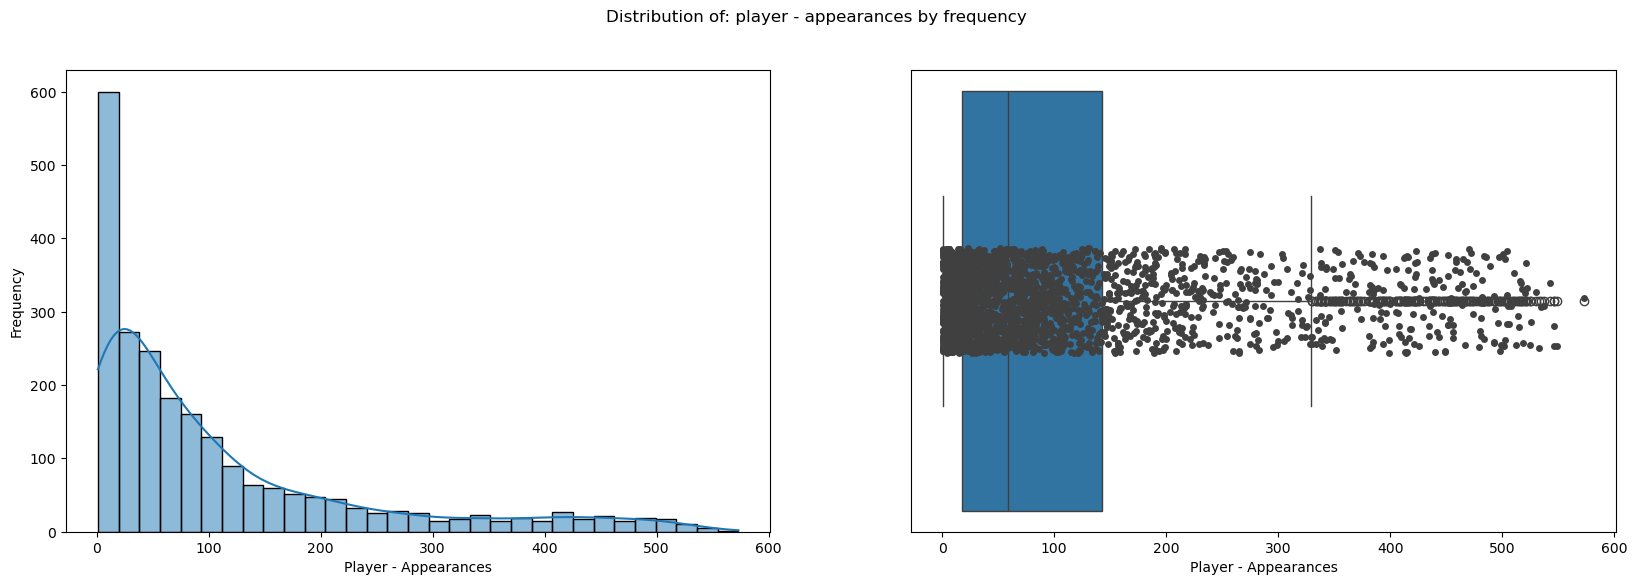

In [13]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_id"]), "frequency", "Player - Appearances", "Frequency")

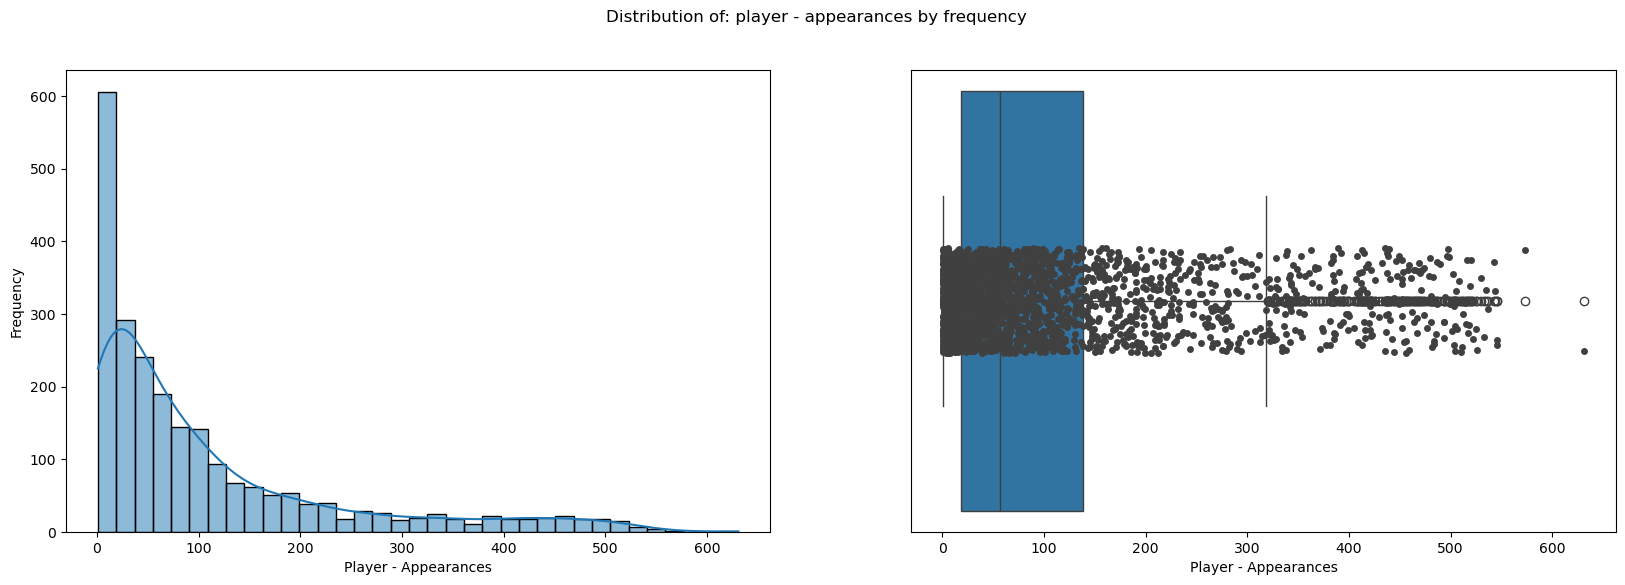

In [14]:
plot_distribution_by_variable(get_frequencies(cleaned_mlb_df, ["player_info__player_name"]), "frequency", "Player - Appearances", "Frequency")

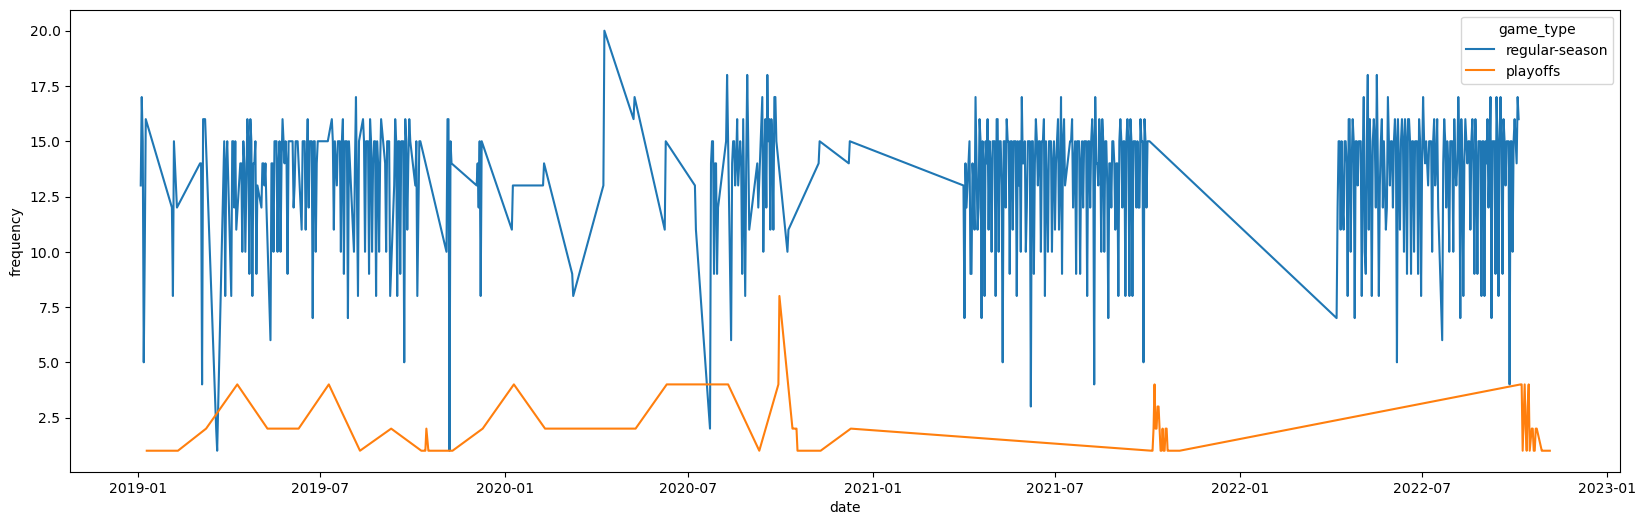

In [15]:
games_per_date = cleaned_mlb_df[["game_info__game_type", "game_info__game_id", "game_info__date"]].drop_duplicates()\
.groupby(["game_info__date", "game_info__game_type"])\
.size()\
.reset_index(name='frequency')\
.rename(columns={"game_info__date": "date", "game_info__game_type": "game_type"})

fig, ax = plt.subplots(figsize=(20, 6))

sns.lineplot(
    data=games_per_date,
    x="date",
    y="frequency",
    hue="game_type",
    ax=ax
)

plt.plot();

In [16]:
def plot_histogram(
    df: pd.DataFrame, 
    filter_column: str, 
    factor: Any, 
    value: str,
    kde: bool = False
) -> Figure:
    fig, ax = plt.subplots(ncols=1, figsize=(16, 8))

    sns.histplot(
        data=df[
        (df[filter_column] == factor) & (~df[value].isna())
        ], 
        x=value, 
        kde=kde,
        bins=100
    )
    ax.set_ylabel('Frecuency')
    ax.set_xlabel(" - ".join(value.split("__")))

    fig.suptitle(f'Distribution of: {value} by factor: {factor}')

    return fig

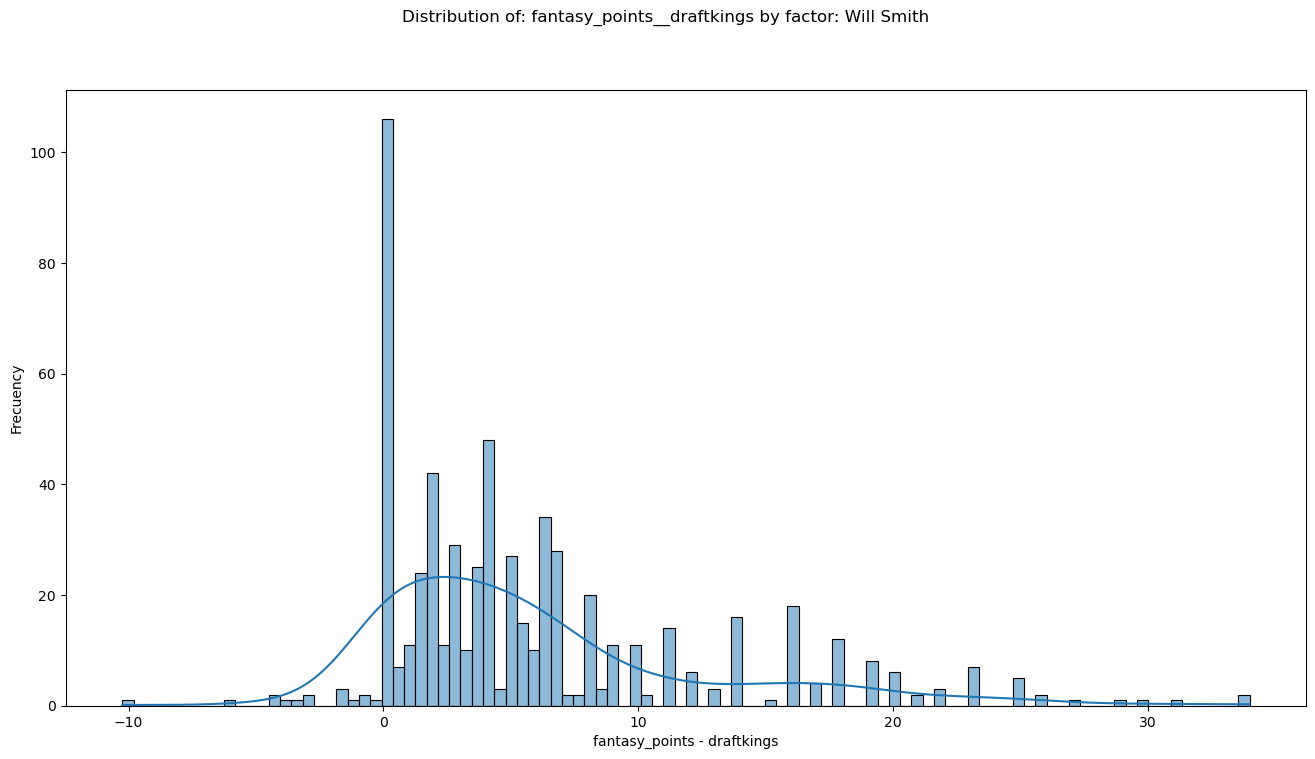

In [17]:
fig = plot_histogram(cleaned_mlb_df, "player_info__player_name", "Will Smith", "fantasy_points__draftkings", True)

## Position

In [18]:
get_frequencies(cleaned_mlb_df, ["position__fanduel"])

position__fanduel  frequency
52                 P      69587
42                OF      58807
31                 C      19887
1                 1B      17444
53                SS      15615
20                3B      15597
10                2B      14718
18             2B/SS       4035
17             2B/OF       2877
22             3B/2B       2163
8              1B/OF       1862
35               C1B       1443
26             3B/SS       1122
13             2B/3B       1109
21             3B/1B       1085
2              1B/2B        828
25             3B/OF        756
55             SS/3B        662
57             SS/OF        656
54             SS/2B        546
5              1B/3B        534
27          3B/SS/2B        320
19          2B/SS/3B        261
56          SS/3B/2B        256
3           1B/2B/3B        245
39            C1B/OF        184
46             OF/3B        142
48              OF/C        127
43             OF/1B         99
12          2B/1B/3B         97
34              C/OF         94
36            C1B/2B         93
38            C1B/3B         87
51             OF/SS         78
44             OF/2B         72
14          2B/3B/SS         72
47          OF/3B/2B         62
28          3B/SS/OF         60
24          3B/2B/SS         52
23          3B/2B/1B         47
6           1B/3B/2B         46
45          OF/2B/SS         26
49            OF/C1B         22
50           OF/CC1B         22
15            2B/C1B         20
16          2B/C1B/3         19
32              C/1B         18
11             2B/1B         18
9              1B/SS         16
41           CC1B/OF         15
7           1B/3B/OF         15
40          CC1B/C1B         13
4           1B/2B/SS         12
37          C1B/2B/S          9
0                  0          3
29              5500          2
33              C/CC          1
30              5700          1

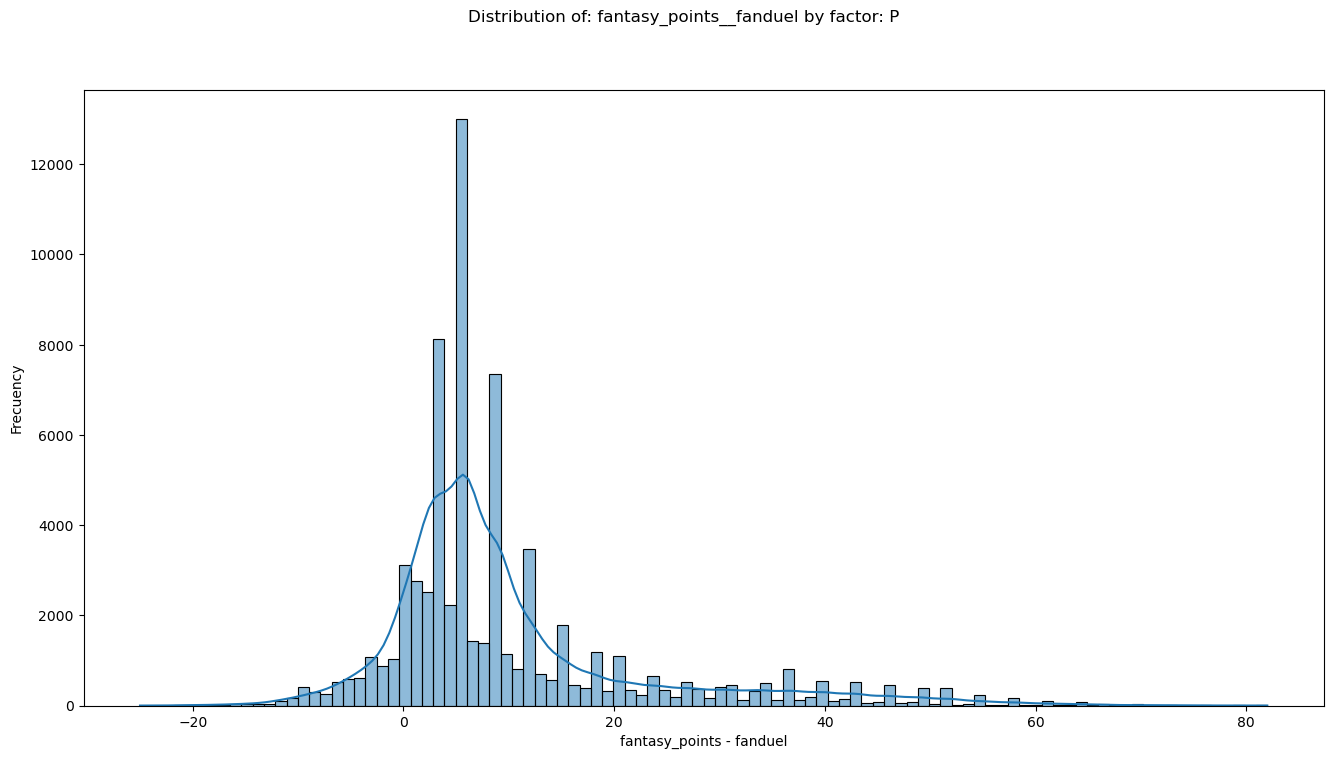

In [19]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "P", "fantasy_points__fanduel", True)

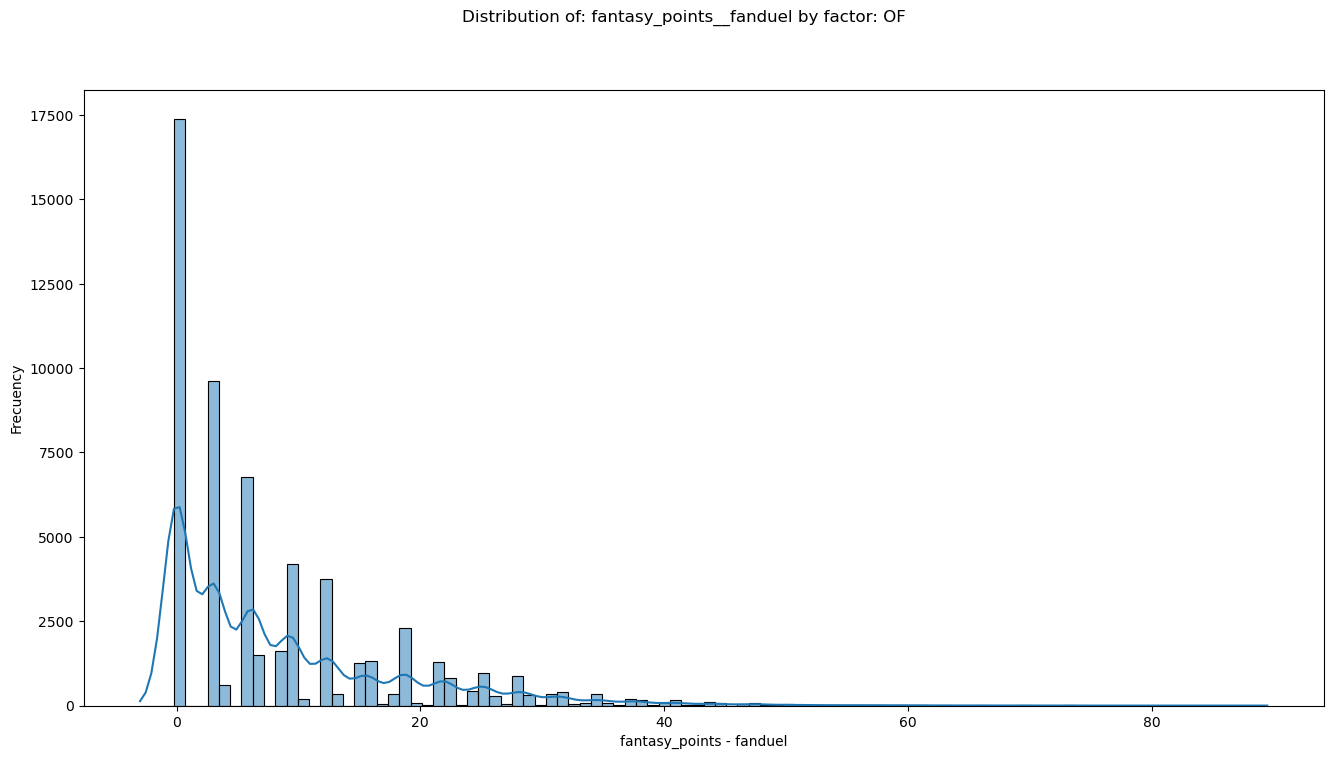

In [20]:
fig = plot_histogram(cleaned_mlb_df, "position__fanduel", "OF", "fantasy_points__fanduel", True)

# Distributions fitting process

In [61]:
class DistributionValidator:
    def validate_goodness_of_fit(
        cls,
        distribution_fitter: DistributionFitter,
        distribution_name: str,
        sample_proportion: float = 0.01,
        **kwargs
    ) -> None:
        theoretical_data, sample_data = cls.sample_data(
            distribution_fitter=distribution_fitter,
            distribution_name=distribution_name,
            sample_proportion=sample_proportion,
        )
        fig, ax = plt.subplots(ncols=3, figsize=(21, 6))

        ax[0] = cls.qq_plot(ax=ax[0], theoretical_data=theoretical_data, sample_data=sample_data, kwargs=kwargs)
        ax[1] = cls.plot_ecdf(ax=ax[1], theoretical_data=theoretical_data, sample_data=sample_data, kwargs=kwargs)
        ax[2] = cls.plot_histogram(
            ax=ax[2], theoretical_data=theoretical_data, sample_data=sample_data, kwargs=kwargs
        )
        
        suptitle = kwargs.get('suptitle', 'Goodness of Fit')
        
        fig.suptitle(suptitle)

        plt.show()

    @classmethod
    def sample_data(
        cls,
        distribution_fitter: DistributionFitter,
        distribution_name: str,
        sample_proportion: float = 0.01,
    ) -> Tuple[np.ndarray, np.ndarray]:
        sample_size = int(np.ceil(distribution_fitter._data.size * sample_proportion))

        sample_data = np.random.choice(distribution_fitter._data, size=sample_size)
        theoretical_distribution = distribution_fitter.get_distribution(
            distribution_name=distribution_name
        )
        theoretical_data = theoretical_distribution.ppf(np.linspace(0.001, 0.999, len(sample_data)))

        theoretical_data = np.sort(theoretical_data)
        sample_data = np.sort(sample_data)

        return theoretical_data, sample_data

    @classmethod
    def qq_plot(
        cls, ax: plt.Axes, theoretical_data: np.ndarray, sample_data: np.ndarray, **kwargs
    ) -> plt.Axes:
        title = kwargs.get('title', 'QQ Plot for Goodness of Fit')
        xlabel = kwargs.get('xlabel', 'Theoretical Quantiles')
        ylabel = kwargs.get('ylabel', 'Sample Quantiles')

        ax.scatter(theoretical_data, sample_data, c='b', marker='o')
        ax.plot(
            [np.min(sample_data), np.max(sample_data)],
            [np.min(sample_data), np.max(sample_data)],
            color='r',
            linestyle='--',
        )
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.grid(True)
        return ax

    @classmethod
    def plot_ecdf(
        cls, ax: plt.Axes, theoretical_data: np.ndarray, sample_data: np.ndarray, **kwargs
    ) -> plt.Axes:
        title = kwargs.get('title', 'ECDF Plot for Goodness of Fit')

        sns.ecdfplot(theoretical_data, label='Theoretical Data', ax=ax)
        sns.ecdfplot(sample_data, label='Sample Data', ax=ax)
        ax.set_title(title)
        ax.legend()
        return ax

    @classmethod
    def plot_histogram(
        cls, ax: plt.Axes, theoretical_data: np.ndarray, sample_data: np.ndarray, **kwargs
    ) -> plt.Axes:
        title = kwargs.get('title', 'Histogram Plot for Goodness of Fit')

        sns.histplot(
            theoretical_data,
            label='Theoretical Data',
            element='step',
            stat='density',
            common_norm=False,
            ax=ax,
        )
        sns.histplot(sample_data, label='Sample Data', stat='density', common_norm=False, ax=ax)
        ax.set_title(title)
        ax.legend()
        return ax

## Fanduel for Pitchers

In [21]:
cleaned_mlb_df.head()

game_info__bigdataball_dataset game_info__game_id game_info__date  \
0        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
1        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
2        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
3        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   
4        MLB 2022 Regular Season    44658-MIL@CHC-1      2022-04-07   

   player_info__player_id player_info__player_name  player_info__team  \
0                543939.0              Kolten Wong  Milwaukee Brewers   
1                642715.0             Willy Adames  Milwaukee Brewers   
2                592885.0         Christian Yelich  Milwaukee Brewers   
3                457705.0         Andrew McCutchen  Milwaukee Brewers   
4                642133.0             Rowdy Tellez  Milwaukee Brewers   

  player_info__opponent player_info__venue position__draftkings  \
0          Chicago Cubs               Road                  NaN   
1          Chicago Cubs               Road                  NaN   
2          Chicago Cubs               Road                  NaN   
3          Chicago Cubs               Road                  NaN   
4          Chicago Cubs               Road                  NaN   

  position__fanduel position__yahoo salary__draftkings  salary__fanduel  \
0                2B             NaN                NaN           2600.0   
1                SS             NaN                NaN           2900.0   
2                OF             NaN                NaN           3300.0   
3                OF             NaN                NaN           2500.0   
4               C1B             NaN                NaN           2200.0   

   salary__yahoo  fantasy_points__draftkings  fantasy_points__fanduel  \
0            NaN                         NaN                      6.2   
1            NaN                         NaN                     12.5   
2            NaN                         NaN                      6.5   
3            NaN                         NaN                     12.2   
4            NaN                         NaN                      9.2   

   fantasy_points__yahoo game_info__game_type  year  
0                    NaN       regular-season  2022  
1                    NaN       regular-season  2022  
2                    NaN       regular-season  2022  
3                    NaN       regular-season  2022  
4                    NaN       regular-season  2022

In [76]:
pitchers_df = cleaned_mlb_df[
    (cleaned_mlb_df.position__draftkings == "P") & 
    (~cleaned_mlb_df['fantasy_points__fanduel'].isna())
    ]

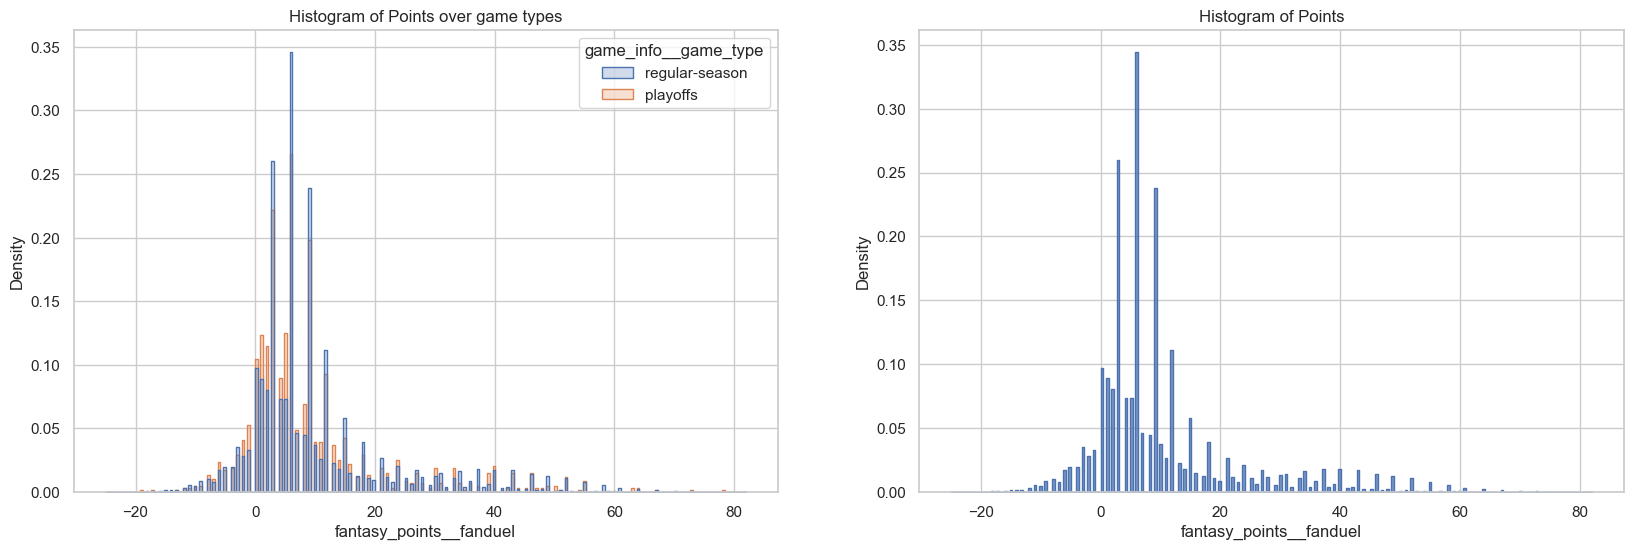

In [23]:
# Setting up style for better visualization
sns.set(style="whitegrid")

# Plotting the histogram
fig, ax = plt.subplots(ncols=2, figsize=(20, 6))

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='game_info__game_type', 
    element='step', 
    stat='density', 
    common_norm=False, # Helps on visualization,
    ax=ax[0]
)

ax[0].set_title("Histogram of Points over game types")

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Points')

plt.show()

### Adding more variables for categorizing players and don't assume a general distribution

In [77]:
statistics_by_pitcher = pitchers_df\
.groupby('player_info__player_id')\
.agg(number_of_observations=pd.NamedAgg("player_info__player_id", "count"))\
.sort_values(by=['number_of_observations'])\
.pipe(lambda df: df.assign(
    cumsum_observations=df.number_of_observations.cumsum(), 
    total_observations=df.number_of_observations.sum()
))\
.pipe(lambda df: df.assign(
    cumulative_proportion=(df.cumsum_observations / df.total_observations) * 100))\
.reset_index()\
.pipe(lambda df: df.assign(
    decile_group=pd.cut(df.cumulative_proportion, bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype("str")
))

In [78]:
pitchers_df = pitchers_df.merge(right=statistics_by_pitcher)

In [79]:
pitchers_df.head()

game_info__bigdataball_dataset game_info__game_id game_info__date  \
0        MLB 2022 Regular Season    44658-CLE@KCR-1      2022-04-07   
1        MLB 2022 Regular Season    44671-CHW@CLE-1      2022-04-20   
2        MLB 2022 Regular Season    44676-CLE@LAA-1      2022-04-25   
3        MLB 2022 Regular Season    44681-CLE@OAK-1      2022-04-30   
4        MLB 2022 Regular Season    44695-CLE@MIN-1      2022-05-14   

   player_info__player_id player_info__player_name    player_info__team  \
0                669456.0             Shane Bieber  Cleveland Guardians   
1                669456.0             Shane Bieber  Cleveland Guardians   
2                669456.0             Shane Bieber  Cleveland Guardians   
3                669456.0             Shane Bieber  Cleveland Guardians   
4                669456.0             Shane Bieber  Cleveland Guardians   

  player_info__opponent player_info__venue position__draftkings  \
0    Kansas City Royals               Road                    P   
1     Chicago White Sox               Home                    P   
2    Los Angeles Angels               Road                    P   
3     Oakland Athletics               Road                    P   
4       Minnesota Twins               Road                    P   

  position__fanduel  ... fantasy_points__draftkings fantasy_points__fanduel  \
0                 P  ...                      14.70                    23.0   
1                 P  ...                      27.10                    46.0   
2                 P  ...                      14.85                    32.0   
3                 P  ...                      22.95                    43.0   
4                 P  ...                      18.90                    40.0   

   fantasy_points__yahoo  game_info__game_type  year  number_of_observations  \
0                   17.3        regular-season  2022                      82   
1                    NaN        regular-season  2022                      82   
2                   16.9        regular-season  2022                      82   
3                   25.8        regular-season  2022                      82   
4                   20.1        regular-season  2022                      82   

   cumsum_observations total_observations  cumulative_proportion  decile_group  
0                29625              65314               45.35781      (40, 50]  
1                29625              65314               45.35781      (40, 50]  
2                29625              65314               45.35781      (40, 50]  
3                29625              65314               45.35781      (40, 50]  
4                29625              65314               45.35781      (40, 50]  

[5 rows x 24 columns]

In [81]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 12))

sns.kdeplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    hue='decile_group', 
    common_norm=False,
    ax=ax[0],
)

ax[0].set_title('Distribution of Fanduel points by Decile of appereances')

sns.histplot(
    data=pitchers_df, 
    x='fantasy_points__fanduel', 
    element='step', 
    stat='density', 
    hue='decile_group', 
    common_norm=False, # Helps on visualization,
    ax=ax[1]
)

ax[1].set_title('Histogram of Fanduel points by Decile of appereances')

plt.show()

### Fitting a general distribution for all the population of pitchers

#### Fitting

In [82]:
data = pitchers_df['fantasy_points__fanduel']

In [30]:
pitchers_distribution_fitter = DistributionFitter(
    distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]], 
    bins=sturges_bins(data)
)

In [31]:
pitchers_distribution_fitter.fit(data)

INFO:distribution_fitter:Fitting distribution: alpha
INFO:distribution_fitter:Fitting distribution: anglit
INFO:distribution_fitter:Fitting distribution: arcsine
INFO:distribution_fitter:Fitting distribution: argus
INFO:distribution_fitter:Fitting distribution: beta
/opt/miniconda3/envs/statistical-simulation/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
INFO:distribution_fitter:Fitting distribution: betaprime
INFO:distribution_fitter:Fitting distribution: bradford
INFO:distribution_fitter:Fitting distribution: burr
INFO:distribution_fitter:Fitting distribution: burr12
INFO:distribution_fitter:Fitting distribution: cauchy
INFO:distribution_fitter:Fitting distribution: chi
INFO:distribution_fitter:Fitting distribution: chi2
INFO:distribution_fitter:Fitting distribution: cosine
INFO:distribution_fitter:Fitting distribution: crystalball
INFO:distribution_fi

In [32]:
pitchers_distribution_fitter.summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic  \
johnsonsu                    johnsonsu       0.261252  3138.514162   
norminvgauss              norminvgauss       0.261025  3164.793302   
nct                                nct       0.261127  3165.863384   
genhyperbolic            genhyperbolic       0.262075  3131.491843   
skewcauchy                  skewcauchy       0.261328  3049.995862   
t                                    t       0.262327  3218.164550   
loglaplace                  loglaplace       0.260357  3357.732436   
tukeylambda                tukeylambda       0.262379  3211.339183   
dgamma                          dgamma       0.249253  3550.338687   
laplace_asymmetric  laplace_asymmetric       0.262761  3277.337308   

                            bic  kullberg_divergence  ks_statistic  \
johnsonsu           3174.862009                  inf      0.076855   
norminvgauss        3201.141149                  inf      0.077840   
nct                 3202.211231                  inf      0.080679   
genhyperbolic       3176.926652                  inf      0.080898   
skewcauchy          3077.256748                  inf      0.092590   
t                   3245.425435                  inf      0.109563   
loglaplace          3384.993321                  inf      0.110175   
tukeylambda         3238.600068                  inf      0.110866   
dgamma              3577.599572                  inf      0.114746   
laplace_asymmetric  3304.598193                  inf      0.115484   

                    ks_p_value  \
johnsonsu                  0.0   
norminvgauss               0.0   
nct                        0.0   
genhyperbolic              0.0   
skewcauchy                 0.0   
t                          0.0   
loglaplace                 0.0   
tukeylambda                0.0   
dgamma                     0.0   
laplace_asymmetric         0.0   

                                                        fitted_params  
johnsonsu           {'a': -0.7397766167090958, 'b': 0.872568120376...  
norminvgauss        {'a': 0.5071916528765518, 'b': 0.3903092384162...  
nct                 {'df': 1.839282323025715, 'nc': 1.210312480973...  
genhyperbolic       {'p': -0.005989684523998585, 'a': 0.3487107208...  
skewcauchy          {'a': 0.4443709805713911, 'loc': 3.23475751284...  
t                   {'df': 1.469173694817656, 'loc': 6.00876240288...  
loglaplace          {'c': 4.5353401344562085, 'loc': -25.073365189...  
tukeylambda         {'lam': -0.5616034558055945, 'loc': 5.99026507...  
dgamma              {'a': 0.8190707446836589, 'loc': 6.00000000000...  
laplace_asymmetric  {'kappa': 0.585114851862595, 'loc': 2.99999999...

#### Validation

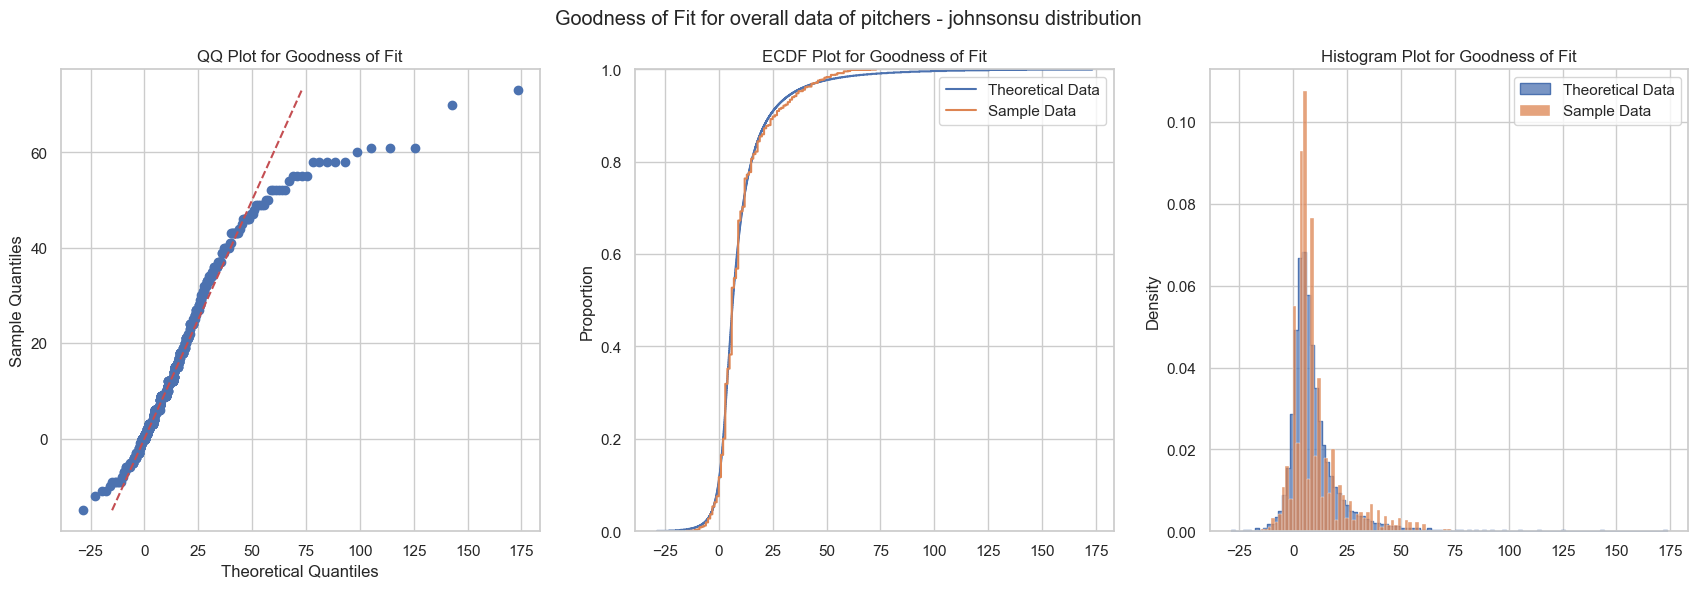

In [115]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="johnsonsu", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - johnsonsu distribution"
)

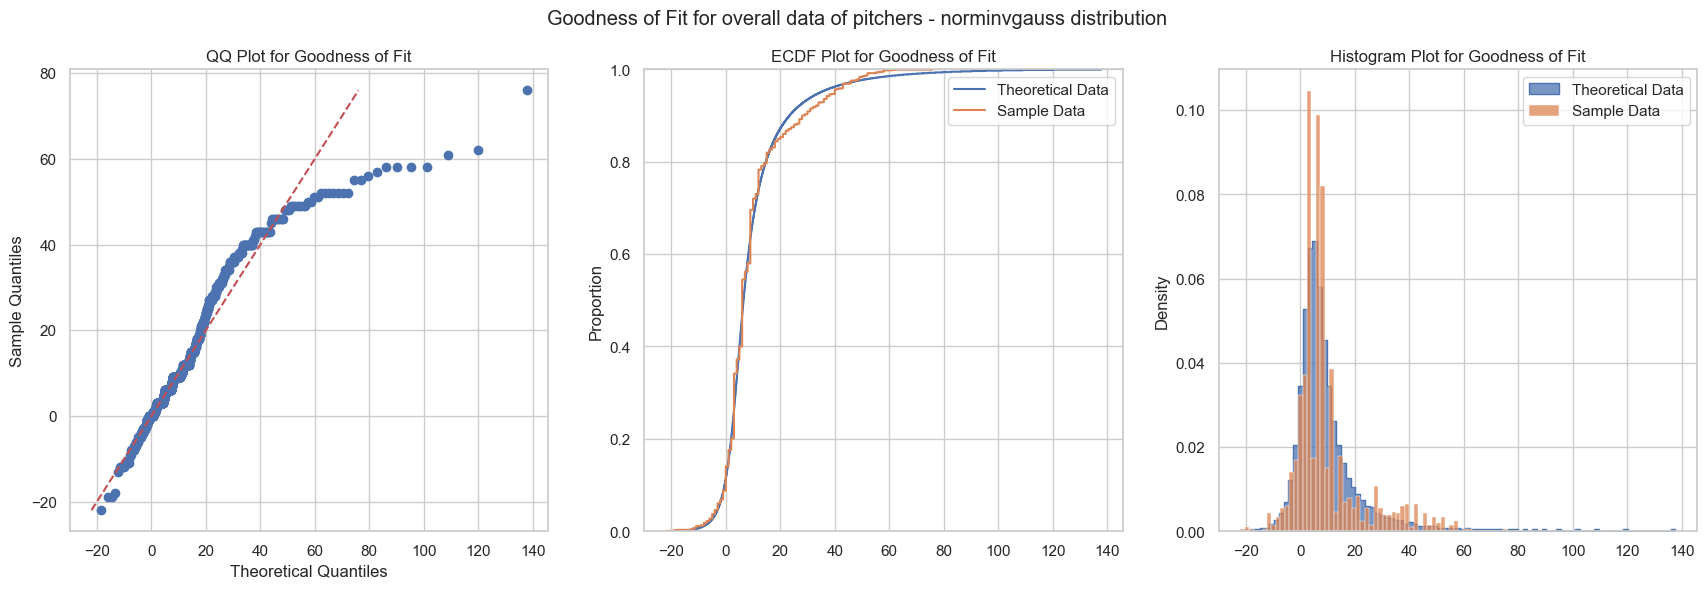

In [114]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="norminvgauss", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - norminvgauss distribution"
)

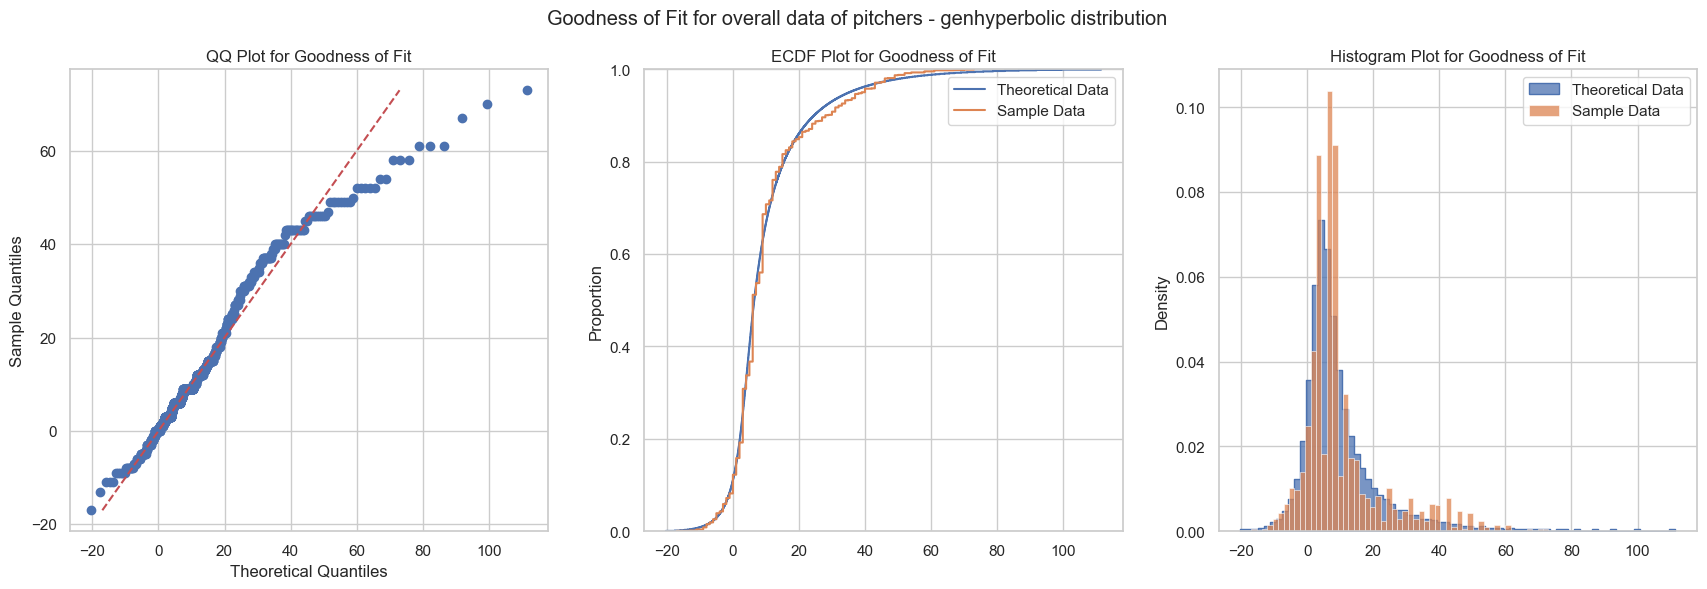

In [116]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="genhyperbolic", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - genhyperbolic distribution"
)

In [137]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=pitchers_distribution_fitter, 
    distribution_name="exponnorm", 
    sample_proportion=0.02, 
    suptitle="Goodness of Fit for overall data of pitchers - exponnorm distribution"
)

### Fitting a distribution by decile

#### Fitting

In [90]:
deciles_groups = pitchers_df.decile_group.unique()

fitters = {}

for decile_group in deciles_groups:

    filtered_data = pitchers_df[pitchers_df.decile_group == decile_group]['fantasy_points__fanduel']
    
    fitter = DistributionFitter(
        distributions=[dist for dist in get_distributions() if dist not in ["levy_stable", "studentized_range", "erlang", "lognorm", "loguniform"]],
        bins=sturges_bins(filtered_data)
    )

    fitter.fit(filtered_data)
    logger.info(f"fitting {decile_group}")
    fitters[decile_group] = fitter

INFO:distribution_fitter:Fitting distribution: alpha
INFO:distribution_fitter:Fitting distribution: anglit
INFO:distribution_fitter:Fitting distribution: arcsine
INFO:distribution_fitter:Fitting distribution: argus
INFO:distribution_fitter:Fitting distribution: beta
INFO:distribution_fitter:Fitting distribution: betaprime
INFO:distribution_fitter:Fitting distribution: bradford
INFO:distribution_fitter:Fitting distribution: burr
INFO:distribution_fitter:Fitting distribution: burr12
INFO:distribution_fitter:Fitting distribution: cauchy
INFO:distribution_fitter:Fitting distribution: chi
INFO:distribution_fitter:Fitting distribution: chi2
INFO:distribution_fitter:Fitting distribution: cosine
INFO:distribution_fitter:Fitting distribution: crystalball
INFO:distribution_fitter:Fitting distribution: dgamma
INFO:distribution_fitter:Fitting distribution: dweibull
INFO:distribution_fitter:Fitting distribution: expon
INFO:distribution_fitter:Fitting distribution: exponnorm
INFO:distribution_fitter

#### Validation

##### **Decile 10%**

In [93]:
fitters['(0, 10]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic  \
norminvgauss              norminvgauss       0.009910   990.632479   
johnsonsu                    johnsonsu       0.009914   990.678020   
laplace_asymmetric  laplace_asymmetric       0.009726  1017.846280   
skewcauchy                  skewcauchy       0.009881   946.009318   
nct                                nct       0.010064   995.578395   
mielke                          mielke       0.011036  1050.113847   
exponnorm                    exponnorm       0.010848  1047.465914   
t                                    t       0.010701  1030.594368   
tukeylambda                tukeylambda       0.010641  1031.574546   
hypsecant                    hypsecant       0.011708  1130.995566   

                            bic  kullberg_divergence  ks_statistic  \
norminvgauss        1017.768515                  inf      0.065634   
johnsonsu           1017.814057                  inf      0.068017   
laplace_asymmetric  1038.198307                  inf      0.069328   
skewcauchy           966.361346                  inf      0.070173   
nct                 1022.714431                  inf      0.073138   
mielke              1077.249883                  inf      0.083067   
exponnorm           1067.817941                  inf      0.084001   
t                   1050.946395                  inf      0.085573   
tukeylambda         1051.926573                  inf      0.086535   
hypsecant           1144.563585                  inf      0.092877   

                      ks_p_value  \
norminvgauss        6.752081e-25   
johnsonsu           1.045288e-26   
laplace_asymmetric  9.896068e-28   
skewcauchy          2.116625e-28   
nct                 8.115897e-31   
mielke              1.223918e-39   
exponnorm           1.580952e-40   
t                   4.810666e-42   
tukeylambda         5.496906e-43   
hypsecant           1.832470e-49   

                                                        fitted_params  
norminvgauss        {'a': 0.7800184943136785, 'b': 0.4986458613943...  
johnsonsu           {'a': -0.7571421364575242, 'b': 1.100276375071...  
laplace_asymmetric  {'kappa': 0.6565418530455536, 'loc': 3.0000000...  
skewcauchy          {'a': 0.370411933965408, 'loc': 3.146728472073...  
nct                 {'df': 2.7788832124066056, 'nc': 1.27731541243...  
mielke              {'k': 42.480236738997945, 's': 10.901793838098...  
exponnorm           {'K': 1.8990902235147513, 'loc': -1.0593229093...  
t                   {'df': 2.292310792245193, 'loc': 6.27905860264...  
tukeylambda         {'lam': -0.3159090683349717, 'loc': 6.21080287...  
hypsecant           {'loc': 6.957068064366244, 'scale': 6.88609043...

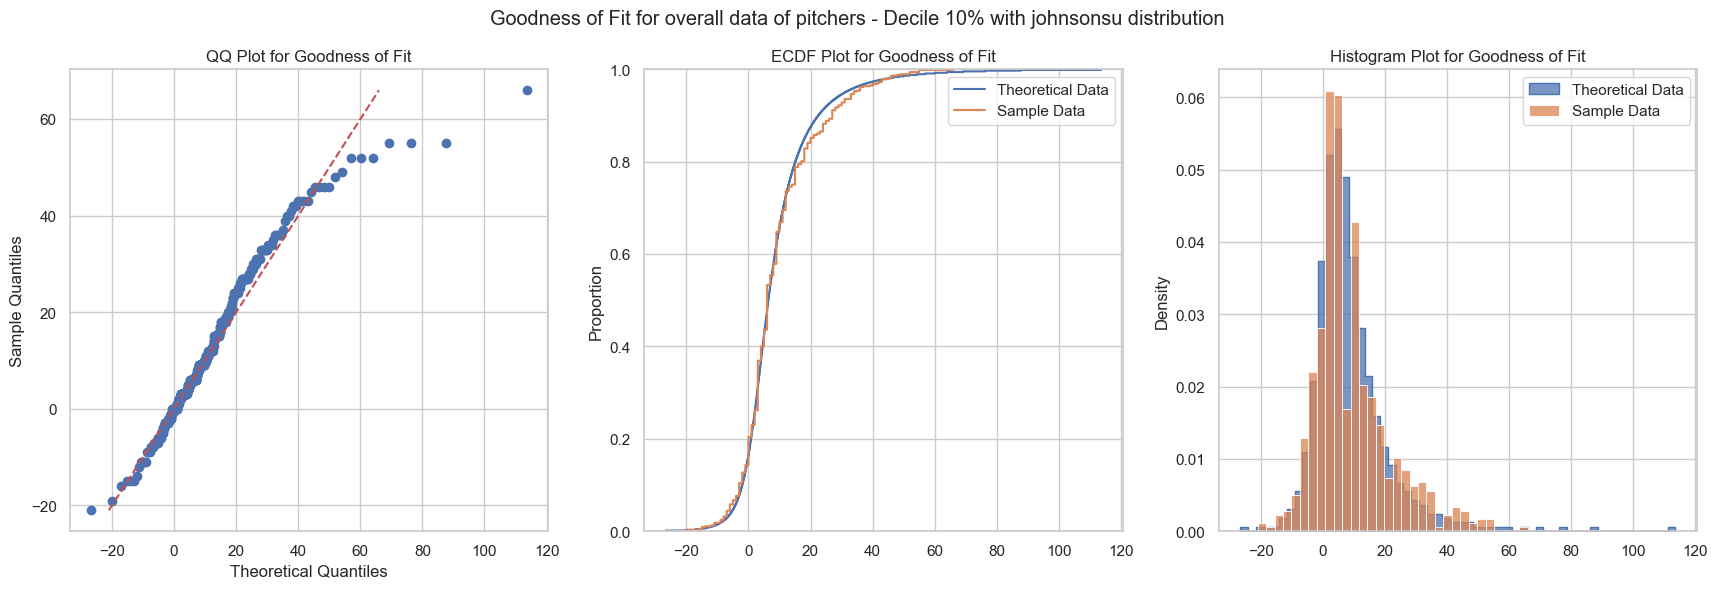

In [101]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(0, 10]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 10% with johnsonsu distribution"
)

In [102]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(0, 10]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 10% with norminvgauss distribution"
)

In [130]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(0, 10]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 10% with exponnorm distribution"
)

##### **Decile 20%**

In [103]:
fitters['(10, 20]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic  \
genhyperbolic            genhyperbolic       0.007816   955.067767   
norminvgauss              norminvgauss       0.008027   961.263152   
johnsonsu                    johnsonsu       0.008057   957.325245   
skewcauchy                  skewcauchy       0.008162   928.971887   
nct                                nct       0.008270   964.380085   
laplace_asymmetric  laplace_asymmetric       0.008044   968.970772   
exponnorm                    exponnorm       0.009418  1022.114739   
mielke                          mielke       0.009684  1031.670482   
t                                    t       0.009317   980.184460   
tukeylambda                tukeylambda       0.009278   978.637391   

                            bic  kullberg_divergence  ks_statistic  \
genhyperbolic        988.983982                  inf      0.062121   
norminvgauss         988.396124                  inf      0.065392   
johnsonsu            984.458217                  inf      0.067125   
skewcauchy           949.321616                  inf      0.070659   
nct                  991.513057                  inf      0.072837   
laplace_asymmetric   989.320501                  inf      0.080080   
exponnorm           1042.464468                  inf      0.094390   
mielke              1058.803454                  inf      0.094817   
t                   1000.534189                  inf      0.102319   
tukeylambda          998.987119                  inf      0.103700   

                      ks_p_value  \
genhyperbolic       2.496738e-22   
norminvgauss        1.068386e-24   
johnsonsu           5.298741e-26   
skewcauchy          9.076835e-29   
nct                 1.520959e-30   
laplace_asymmetric  7.717696e-37   
exponnorm           4.873611e-51   
mielke              1.689633e-51   
t                   6.443526e-60   
tukeylambda         1.545523e-61   

                                                        fitted_params  
genhyperbolic       {'p': 0.43940765660036174, 'a': 0.333103657172...  
norminvgauss        {'a': 0.76854639104122, 'b': 0.560893862578742...  
johnsonsu           {'a': -0.8571517771456736, 'b': 1.013156707419...  
skewcauchy          {'a': 0.4368923946384451, 'loc': 3.05495358826...  
nct                 {'df': 2.3377571703104714, 'nc': 1.41354305975...  
laplace_asymmetric  {'kappa': 0.6063945628554734, 'loc': 2.9999999...  
exponnorm           {'K': 2.2785182068733314, 'loc': -0.9343444934...  
mielke              {'k': 30.79444407218036, 's': 7.86441223028769...  
t                   {'df': 1.8815758530389781, 'loc': 6.5131072356...  
tukeylambda         {'lam': -0.4086059261583101, 'loc': 6.45804099...

In [105]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with genhyperbolic distribution"
)

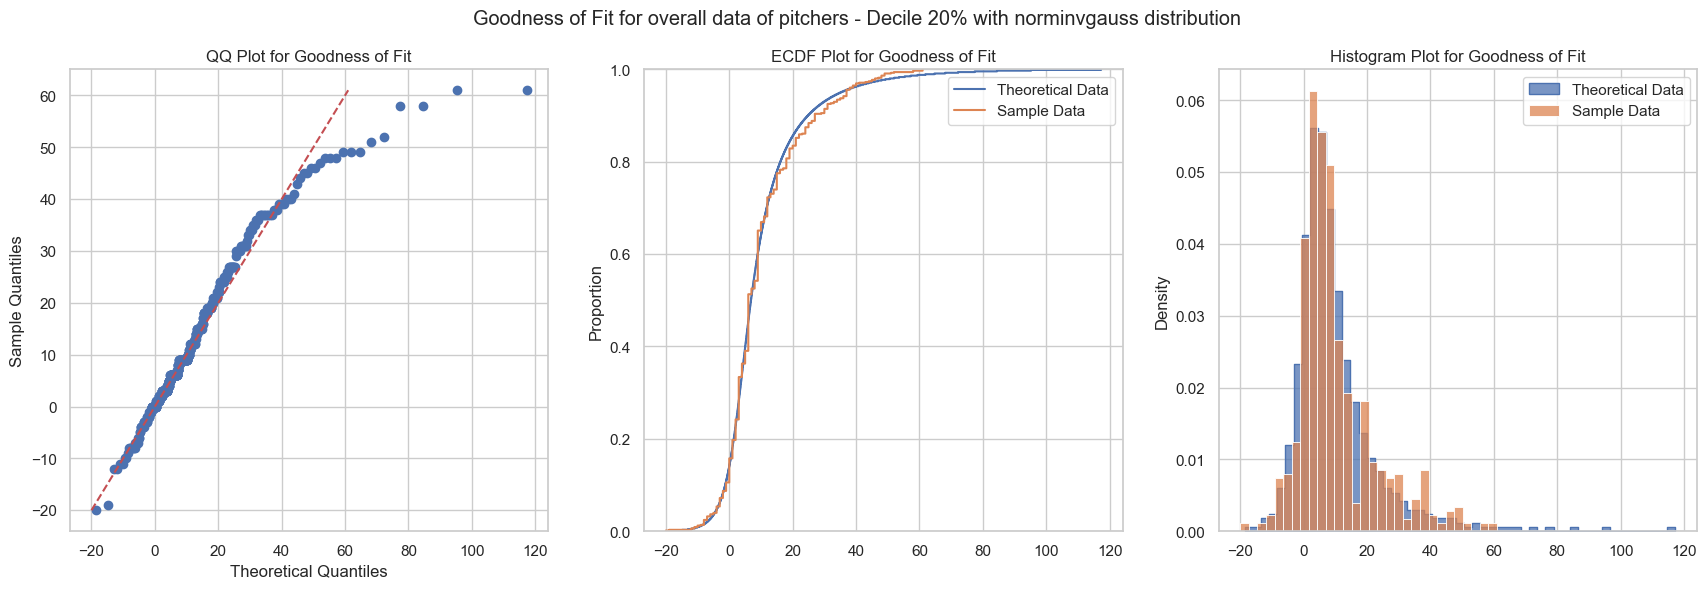

In [106]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with norminvgauss distribution"
)

In [107]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with johnsonsu distribution"
)

In [131]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(10, 20]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 20% with exponnorm distribution"
)

##### **Decile 30%**

In [108]:
fitters['(20, 30]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic  \
genhyperbolic            genhyperbolic       0.013950   941.532944   
skewcauchy                  skewcauchy       0.014098   923.952376   
norminvgauss              norminvgauss       0.014477   961.154002   
johnsonsu                    johnsonsu       0.014470   946.966148   
nct                                nct       0.014832   955.897532   
burr12                          burr12       0.015282  1080.601722   
laplace_asymmetric  laplace_asymmetric       0.014382   950.631534   
loglaplace                  loglaplace       0.015987   967.887557   
burr                              burr       0.016449  1048.732555   
exponnorm                    exponnorm       0.016082  1049.699010   

                            bic  kullberg_divergence  ks_statistic  \
genhyperbolic        975.431501                  inf      0.069313   
skewcauchy           944.291510                  inf      0.074716   
norminvgauss         988.272847                  inf      0.074809   
johnsonsu            974.084993                  inf      0.076624   
nct                  983.016378                  inf      0.082590   
burr12              1107.720567                  inf      0.086312   
laplace_asymmetric   970.970668                  inf      0.098343   
loglaplace           988.226691                  inf      0.106633   
burr                1075.851400                  inf      0.108806   
exponnorm           1070.038144                  inf      0.109512   

                      ks_p_value  \
genhyperbolic       1.332407e-27   
skewcauchy          5.233437e-32   
norminvgauss        4.366106e-32   
johnsonsu           1.212494e-33   
nct                 5.048080e-39   
burr12              1.382933e-42   
laplace_asymmetric  3.509962e-55   
loglaplace          7.995774e-65   
burr                1.756125e-67   
exponnorm           2.343966e-68   

                                                        fitted_params  
genhyperbolic       {'p': 0.46496017809696405, 'a': 0.279017847385...  
skewcauchy          {'a': 0.5066817960089016, 'loc': 3.12934361700...  
norminvgauss        {'a': 0.8479906884947868, 'b': 0.6765392199049...  
johnsonsu           {'a': -0.9615113942917979, 'b': 0.963337056287...  
nct                 {'df': 2.1426691199911305, 'nc': 1.60739097550...  
burr12              {'c': 8.49510752018211, 'd': 0.426056574293561...  
laplace_asymmetric  {'kappa': 0.5500510340184319, 'loc': 2.9999993...  
loglaplace          {'c': 4.002264821676967, 'loc': -25.2933887020...  
burr                {'c': 5.2497502601949595, 'd': 2.5697872599250...  
exponnorm           {'K': 2.783241977010988, 'loc': -0.71426869917...

In [109]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with genhyperbolic distribution"
)

In [111]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with norminvgauss distribution"
)

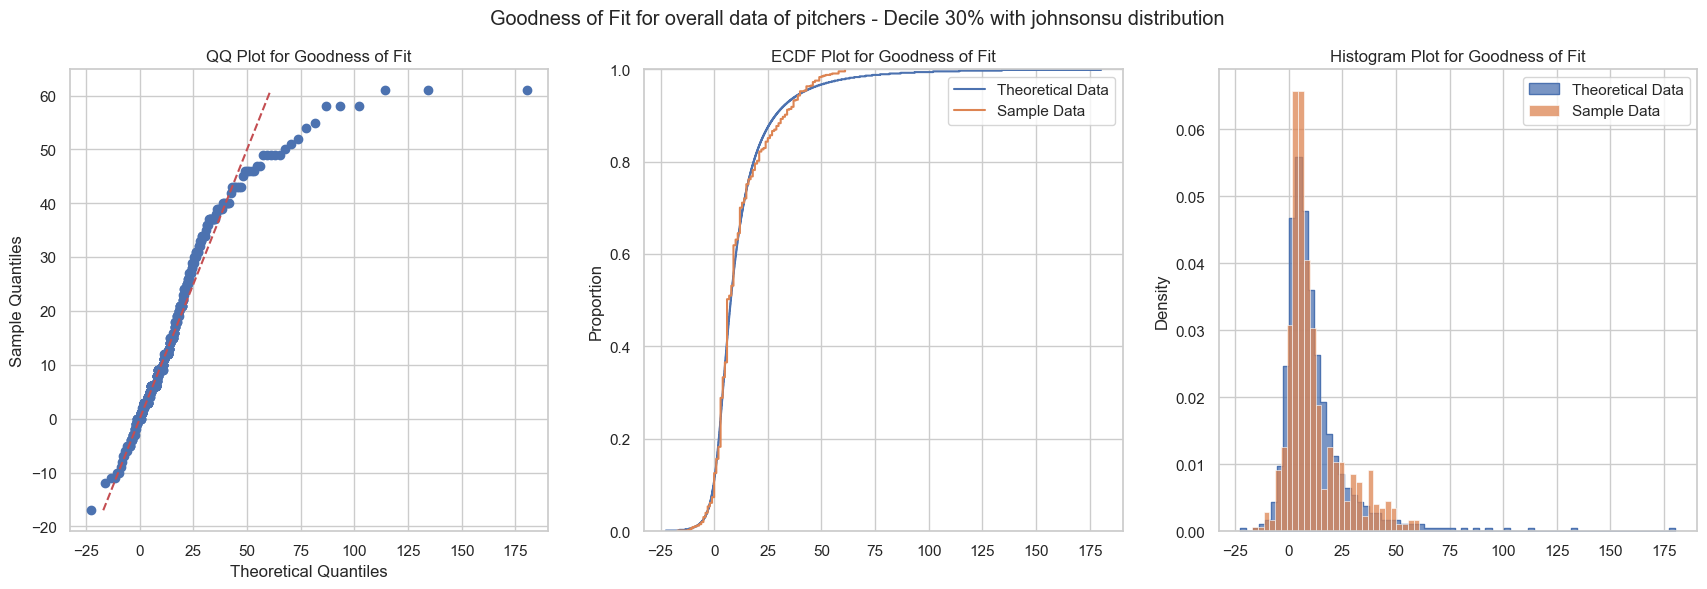

In [112]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with johnsonsu distribution"
)

In [132]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(20, 30]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 30% with exponnorm distribution"
)

##### **Decile 40%**

In [117]:
fitters['(30, 40]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic  \
genhyperbolic            genhyperbolic       0.007204   928.855781   
laplace_asymmetric  laplace_asymmetric       0.007376   935.582777   
norminvgauss              norminvgauss       0.007988   956.249624   
johnsonsu                    johnsonsu       0.007921   944.860535   
nct                                nct       0.008341   952.396851   
burr12                          burr12       0.008185   953.074318   
skewcauchy                  skewcauchy       0.007525   920.658985   
exponnorm                    exponnorm       0.008359   994.802026   
moyal                            moyal       0.009145  1061.047660   
mielke                          mielke       0.009012   992.738058   

                            bic  kullberg_divergence  ks_statistic  \
genhyperbolic        962.755875                  inf      0.061316   
laplace_asymmetric   955.922834                  inf      0.067864   
norminvgauss         983.369700                  inf      0.072687   
johnsonsu            971.980610                  inf      0.073967   
nct                  979.516926                  inf      0.081586   
burr12               980.194393                  inf      0.082432   
skewcauchy           940.999042                  inf      0.083036   
exponnorm           1015.142083                  inf      0.084004   
moyal               1074.607698                  inf      0.098646   
mielke              1019.858133                  inf      0.099709   

                      ks_p_value  \
genhyperbolic       1.070881e-21   
laplace_asymmetric  1.744920e-26   
norminvgauss        2.528896e-30   
johnsonsu           2.186264e-31   
nct                 4.219612e-38   
burr12              6.897893e-39   
skewcauchy          1.874570e-39   
exponnorm           2.272624e-40   
moyal               1.549290e-55   
mielke              9.833795e-57   

                                                        fitted_params  
genhyperbolic       {'p': 0.8627926547432586, 'a': 0.0396014450293...  
laplace_asymmetric  {'kappa': 0.5008326323129763, 'loc': 2.9999999...  
norminvgauss        {'a': 1.6351547880936717, 'b': 1.3357202395710...  
johnsonsu           {'a': -1.3138022271465726, 'b': 1.143063179121...  
nct                 {'df': 2.9129692132822083, 'nc': 2.29078900626...  
burr12              {'c': 50.17013259044455, 'd': 0.24877337722551...  
skewcauchy          {'a': 0.5941492080754659, 'loc': 3.05184317620...  
exponnorm           {'K': 3.043641518158824, 'loc': -0.58583422794...  
moyal               {'loc': 5.740133281703104, 'scale': 7.53818312...  
mielke              {'k': 40.25689314505198, 's': 7.01805102220835...

In [118]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with genhyperbolic distribution"
)

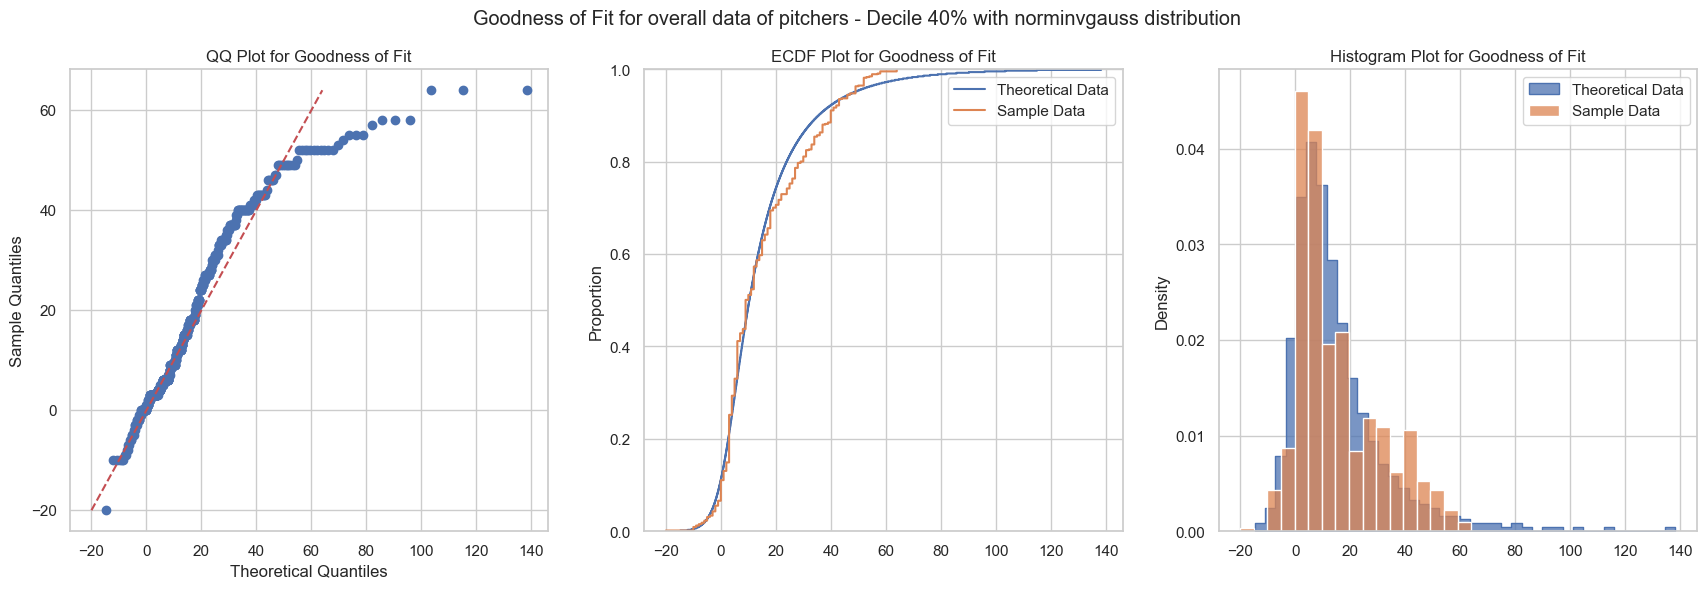

In [119]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with norminvgauss distribution"
)

In [120]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with johnsonsu distribution"
)

In [133]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(30, 40]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 40% with exponnorm distribution"
)

##### **Decile 50%**

In [121]:
fitters['(40, 50]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error         aic         bic  \
skewcauchy                  skewcauchy       0.010696  914.335213  934.700993   
norminvgauss              norminvgauss       0.010796  926.966979  954.121352   
johnsonsu                    johnsonsu       0.010781  922.486003  949.640377   
nct                                nct       0.011223  930.034707  957.189081   
laplace_asymmetric  laplace_asymmetric       0.010807  919.215164  939.580944   
burr12                          burr12       0.011739  934.588796  961.743169   
exponnorm                    exponnorm       0.012091  942.771126  963.136906   
mielke                          mielke       0.012558  946.245593  973.399967   
fisk                              fisk       0.013254  933.755873  954.121653   
alpha                            alpha       0.013224  949.362269  969.728049   

                    kullberg_divergence  ks_statistic    ks_p_value  \
skewcauchy                          inf      0.070913  3.985896e-29   
norminvgauss                        inf      0.073003  7.625844e-31   
johnsonsu                           inf      0.074519  4.027981e-32   
nct                                 inf      0.082292  4.358047e-39   
laplace_asymmetric                  inf      0.097363  1.426930e-54   
burr12                              inf      0.099653  3.735263e-57   
exponnorm                           inf      0.100943  1.233608e-58   
mielke                              inf      0.101343  4.244342e-59   
fisk                                inf      0.105339  7.932544e-64   
alpha                               inf      0.114240  5.041369e-75   

                                                        fitted_params  
skewcauchy          {'a': 0.6020895731245098, 'loc': 2.34692028001...  
norminvgauss        {'a': 1.1778920114333553, 'b': 0.9974040584504...  
johnsonsu           {'a': -1.1672317970860102, 'b': 0.983951734384...  
nct                 {'df': 2.1852027695102327, 'nc': 1.98059699984...  
laplace_asymmetric  {'kappa': 0.5170312097681863, 'loc': 2.9999999...  
burr12              {'c': 416.7855721398523, 'd': 0.16687375223695...  
exponnorm           {'K': 3.3844096896853135, 'loc': -1.0041360690...  
mielke              {'k': 13.414329245430306, 's': 4.3204979448320...  
fisk                {'c': 4.030057263119804, 'loc': -18.6710892262...  
alpha               {'a': 4.206850425646895, 'loc': -40.5923770158...

In [126]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(40, 50]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 50% with norminvgauss distribution"
)

In [128]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(40, 50]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 50% with johnsonsu distribution"
)

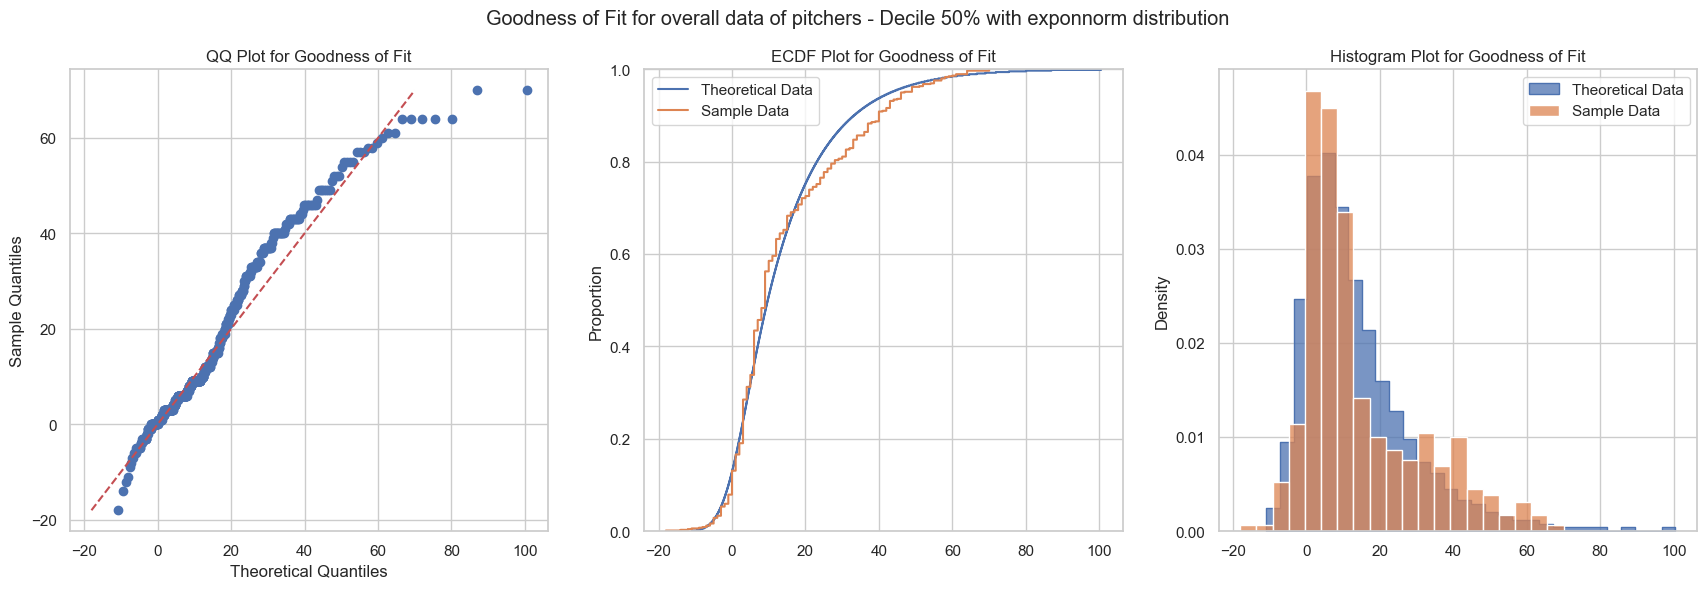

In [129]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(40, 50]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 50% with exponnorm distribution"
)

##### **Decile 60%**

In [138]:
fitters['(50, 60]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error         aic         bic  \
skewcauchy                  skewcauchy       0.014087  905.905801  926.232449   
norminvgauss              norminvgauss       0.014216  910.061041  937.163239   
johnsonsu                    johnsonsu       0.014189  905.506200  932.608398   
burr12                          burr12       0.014749  922.310500  949.412698   
nct                                nct       0.014510  913.341846  940.444044   
loglaplace                  loglaplace       0.015753  906.793666  927.120314   
laplace_asymmetric  laplace_asymmetric       0.014740  895.157909  915.484558   
mielke                          mielke       0.016102  923.209575  950.311773   
exponnorm                    exponnorm       0.015690  916.277376  936.604024   
fisk                              fisk       0.016812  909.474616  929.801264   

                    kullberg_divergence  ks_statistic    ks_p_value  \
skewcauchy                          inf      0.065562  1.227631e-24   
norminvgauss                        inf      0.073689  5.118314e-31   
johnsonsu                           inf      0.075328  2.148067e-32   
burr12                              inf      0.076477  2.228147e-33   
nct                                 inf      0.082419  1.052853e-38   
loglaplace                          inf      0.094369  1.251516e-50   
laplace_asymmetric                  inf      0.115544  9.411329e-76   
mielke                              inf      0.116100  1.755978e-76   
exponnorm                           inf      0.118780  4.806683e-80   
fisk                                inf      0.118952  2.818344e-80   

                                                        fitted_params  
skewcauchy          {'a': 0.5667260024461495, 'loc': 3.00112307361...  
norminvgauss        {'a': 1.0229347346741742, 'b': 0.8781264643087...  
johnsonsu           {'a': -1.0946443012562577, 'b': 0.913704524858...  
burr12              {'c': 18.598030388791145, 'd': 0.2392083323797...  
nct                 {'df': 1.9383018210750182, 'nc': 1.84236221615...  
loglaplace          {'c': 2.8332427429174123, 'loc': -18.307222998...  
laplace_asymmetric  {'kappa': 0.5074290614136829, 'loc': 3.0000000...  
mielke              {'k': 12.234348063962774, 's': 4.0661080527586...  
exponnorm           {'K': 3.497188953740185, 'loc': -1.10775892552...  
fisk                {'c': 3.863827981233161, 'loc': -18.4640629937...

In [140]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(50, 60]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 60% with norminvgauss distribution"
)

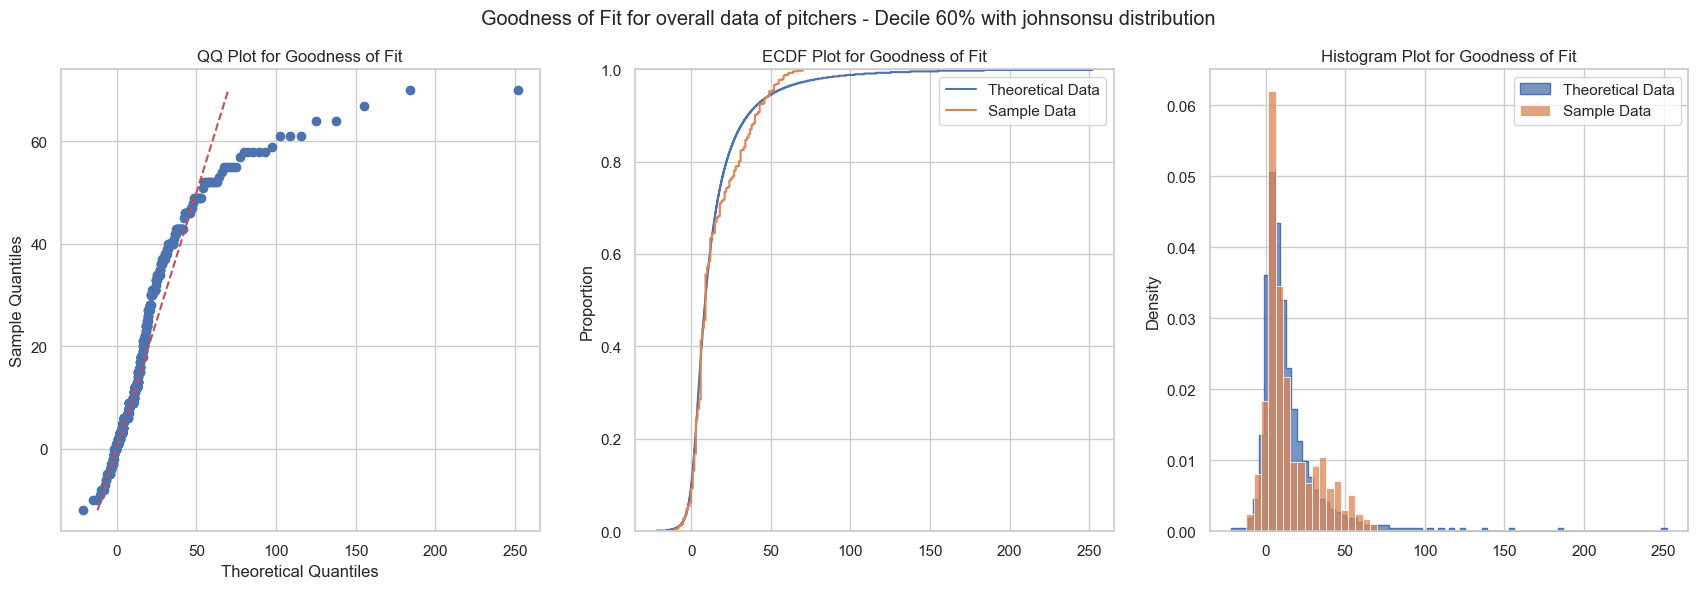

In [141]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(50, 60]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 60% with johnsonsu distribution"
)

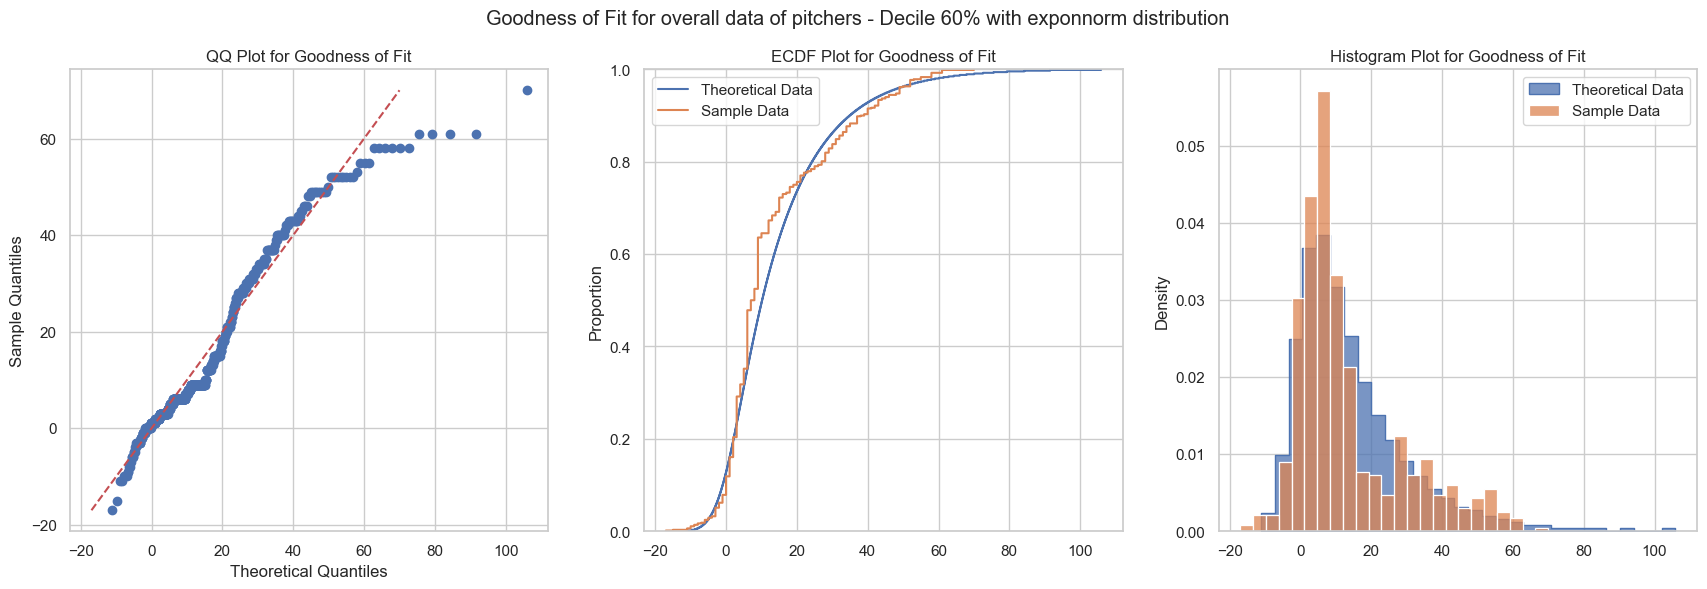

In [142]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(50, 60]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 60% with exponnorm distribution"
)

##### **Decile 70%**

In [143]:
fitters['(60, 70]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
johnsonsu          johnsonsu       0.017118   965.137125   992.292108   
nct                      nct       0.016855   976.294900  1003.449883   
norminvgauss    norminvgauss       0.017019   971.687488   998.842472   
genhyperbolic  genhyperbolic       0.017633   960.155062   994.098792   
skewcauchy        skewcauchy       0.017177   950.959444   971.325681   
loglaplace        loglaplace       0.017227  1011.966568  1032.332806   
burr12                burr12       0.018328  1014.494643  1041.649627   
t                          t       0.016975  1000.354858  1020.721095   
tukeylambda      tukeylambda       0.017048   997.136850  1017.503088   
cauchy                cauchy       0.017292   982.361024   995.938516   

               kullberg_divergence  ks_statistic     ks_p_value  \
johnsonsu                      inf      0.078806   6.974615e-36   
nct                            inf      0.079448   1.835004e-36   
norminvgauss                   inf      0.080171   4.010977e-37   
genhyperbolic                  inf      0.081902   9.996394e-39   
skewcauchy                     inf      0.091794   1.492921e-48   
loglaplace                     inf      0.107857   6.529936e-67   
burr12                         inf      0.117213   5.564817e-79   
t                              inf      0.121862   2.349552e-85   
tukeylambda                    inf      0.122400   4.134966e-86   
cauchy                         inf      0.133824  6.480009e-103   

                                                   fitted_params  
johnsonsu      {'a': -0.7760536712625934, 'b': 0.824234925853...  
nct            {'df': 1.6532705365071698, 'nc': 1.26029361691...  
norminvgauss   {'a': 0.48173195230666477, 'b': 0.394926905737...  
genhyperbolic  {'p': -0.10962008610856054, 'a': 0.34371167565...  
skewcauchy     {'a': 0.45911811357344245, 'loc': 3.1441299776...  
loglaplace     {'c': 3.989489778231298, 'loc': -21.3824094654...  
burr12         {'c': 20.558959190098847, 'd': 0.2882771615624...  
t              {'df': 1.3014505566404144, 'loc': 5.7835607017...  
tukeylambda    {'lam': -0.6522456357238715, 'loc': 5.77560156...  
cauchy         {'loc': 5.665486858122456, 'scale': 3.94655401...

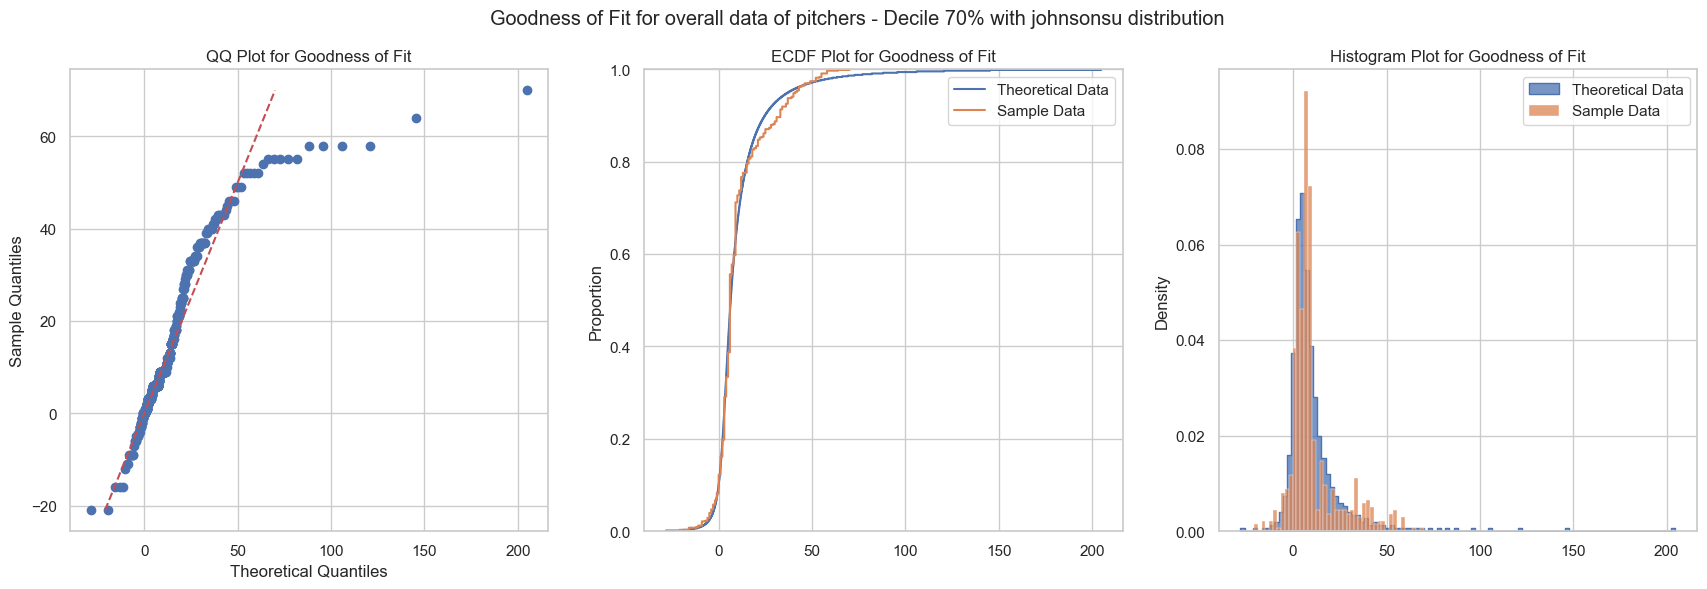

In [145]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with johnsonsu distribution"
)

In [146]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with norminvgauss distribution"
)

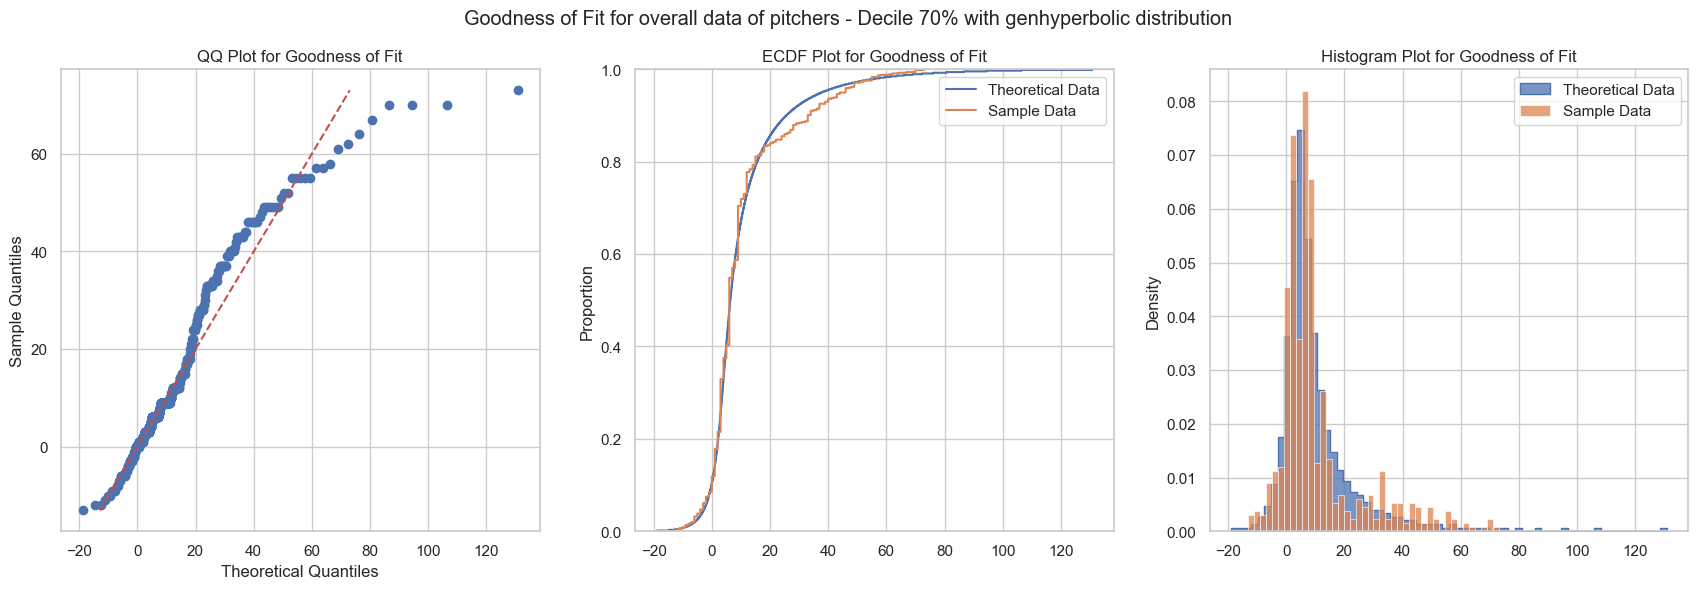

In [147]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with genhyperbolic distribution"
)

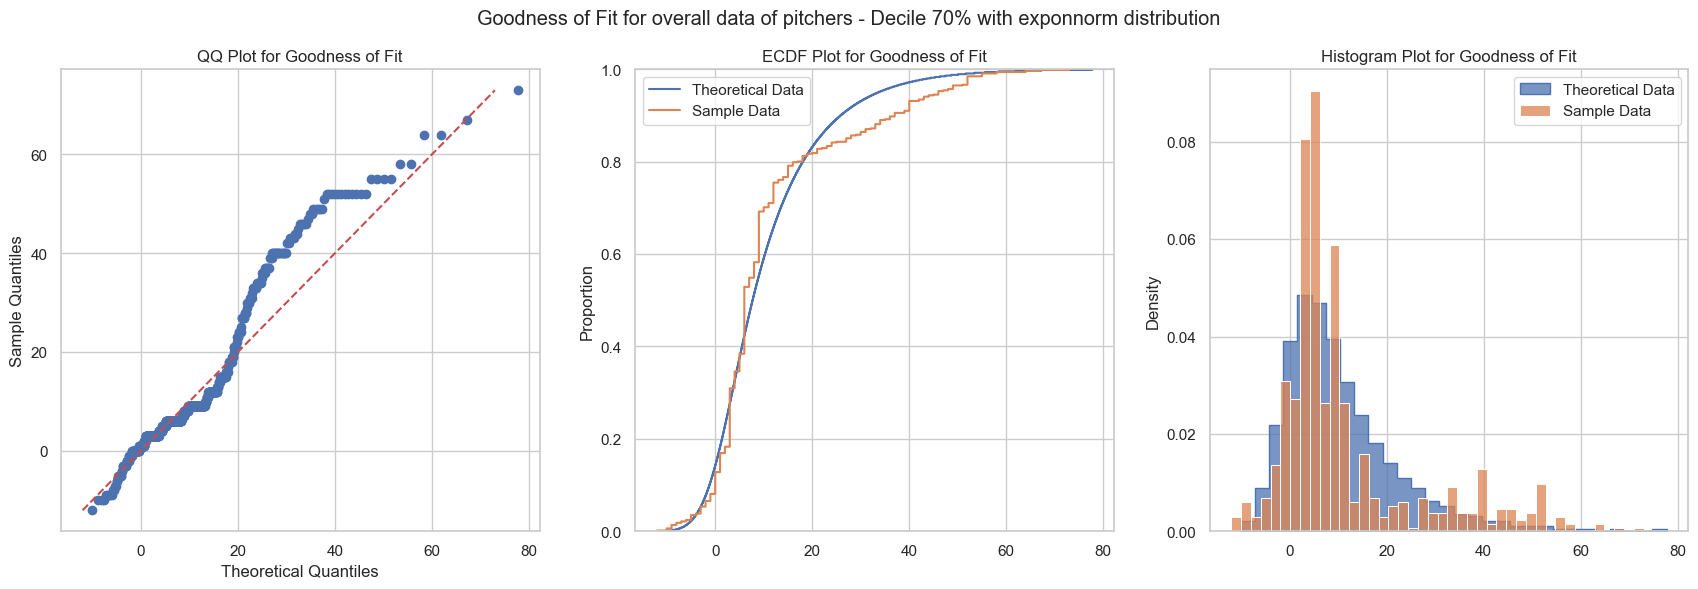

In [150]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(60, 70]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 70% with exponnorm distribution"
)

##### **Decile 80%**

In [151]:
fitters['(70, 80]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
tukeylambda      tukeylambda       0.090255  1006.876510  1027.260530   
t                          t       0.090196  1003.341377  1023.725397   
nct                      nct       0.090072   992.410089  1019.588782   
genhyperbolic  genhyperbolic       0.090147   992.460257  1026.433624   
johnsonsu          johnsonsu       0.090137   994.492734  1021.671428   
norminvgauss    norminvgauss       0.090238   996.637763  1023.816456   
burr12                burr12       0.090422  1070.773976  1097.952670   
hypsecant          hypsecant       0.090302  1082.853099  1096.442446   
mielke                mielke       0.090589  1088.257879  1115.436572   
exponnorm          exponnorm       0.092095  1136.099956  1156.483976   

               kullberg_divergence  ks_statistic    ks_p_value  \
tukeylambda                    inf      0.105142  5.653016e-64   
t                              inf      0.105239  4.305567e-64   
nct                            inf      0.106032  4.658504e-65   
genhyperbolic                  inf      0.107123  2.133140e-66   
johnsonsu                      inf      0.107760  3.464122e-67   
norminvgauss                   inf      0.108458  4.683758e-68   
burr12                         inf      0.110231  2.728377e-70   
hypsecant                      inf      0.110989  2.942966e-71   
mielke                         inf      0.111079  2.255143e-71   
exponnorm                      inf      0.112579  2.628721e-73   

                                                   fitted_params  
tukeylambda    {'lam': -0.16432562713891324, 'loc': 5.3200355...  
t              {'df': 3.480768629504184, 'loc': 5.32409455594...  
nct            {'df': 3.576784493224766, 'nc': 0.386435017145...  
genhyperbolic  {'p': -1.072931196524395, 'a': 0.6881721114121...  
johnsonsu      {'a': -0.24393793128313543, 'b': 1.30238562233...  
norminvgauss   {'a': 0.7868953253441713, 'b': 0.1595741432920...  
burr12         {'c': 56.604057225244276, 'd': 0.7253672743081...  
hypsecant      {'loc': 5.362912895507067, 'scale': 3.47386560...  
mielke         {'k': 7.87412051935603, 's': 11.09810129945015...  
exponnorm      {'K': 0.8555942683647211, 'loc': 2.02038114286...

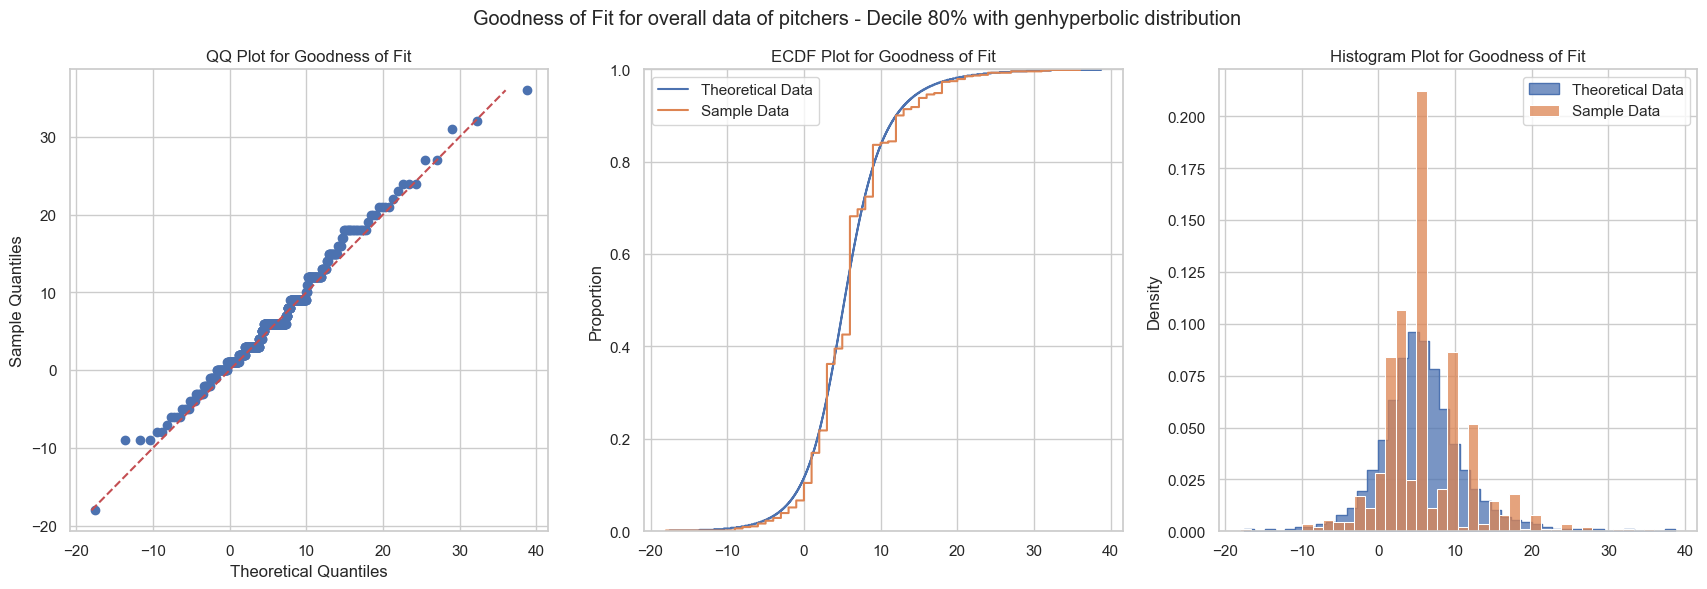

In [153]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="genhyperbolic", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with genhyperbolic distribution"
)

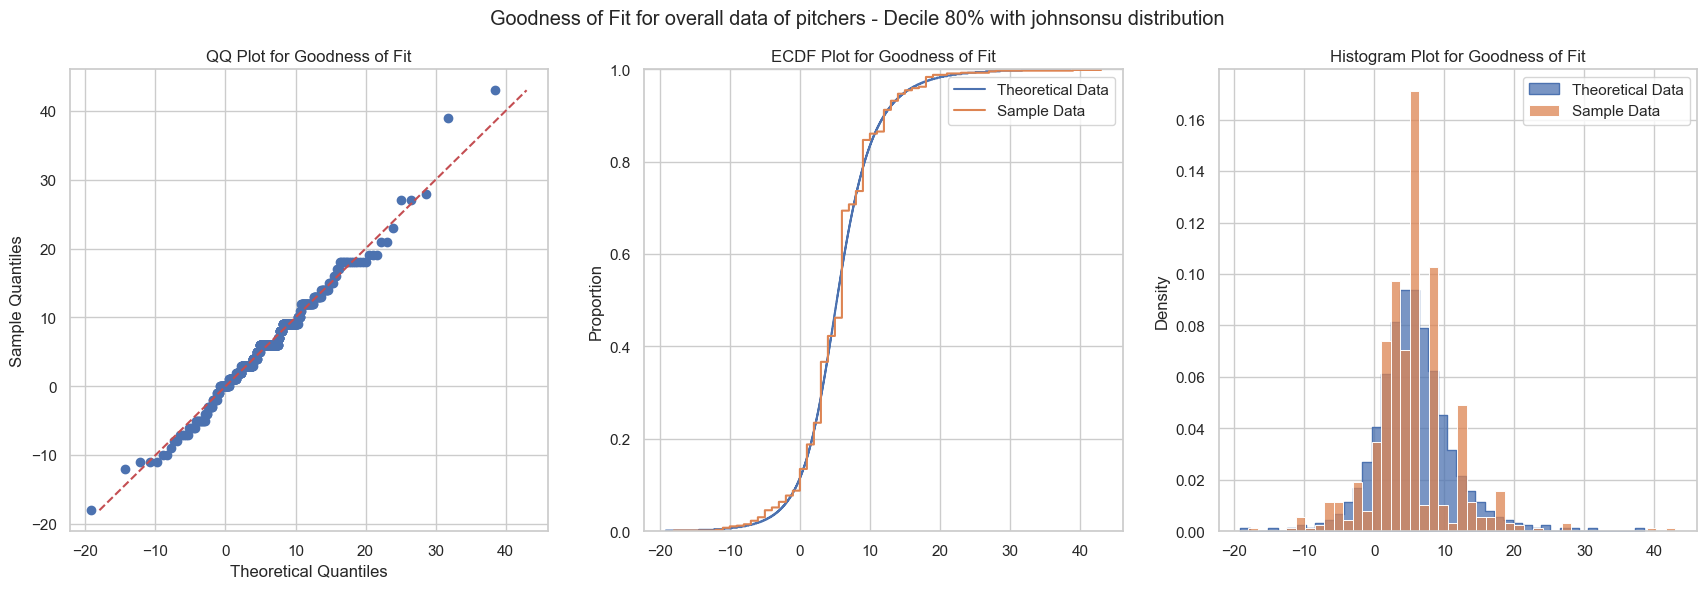

In [154]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with johnsonsu distribution"
)

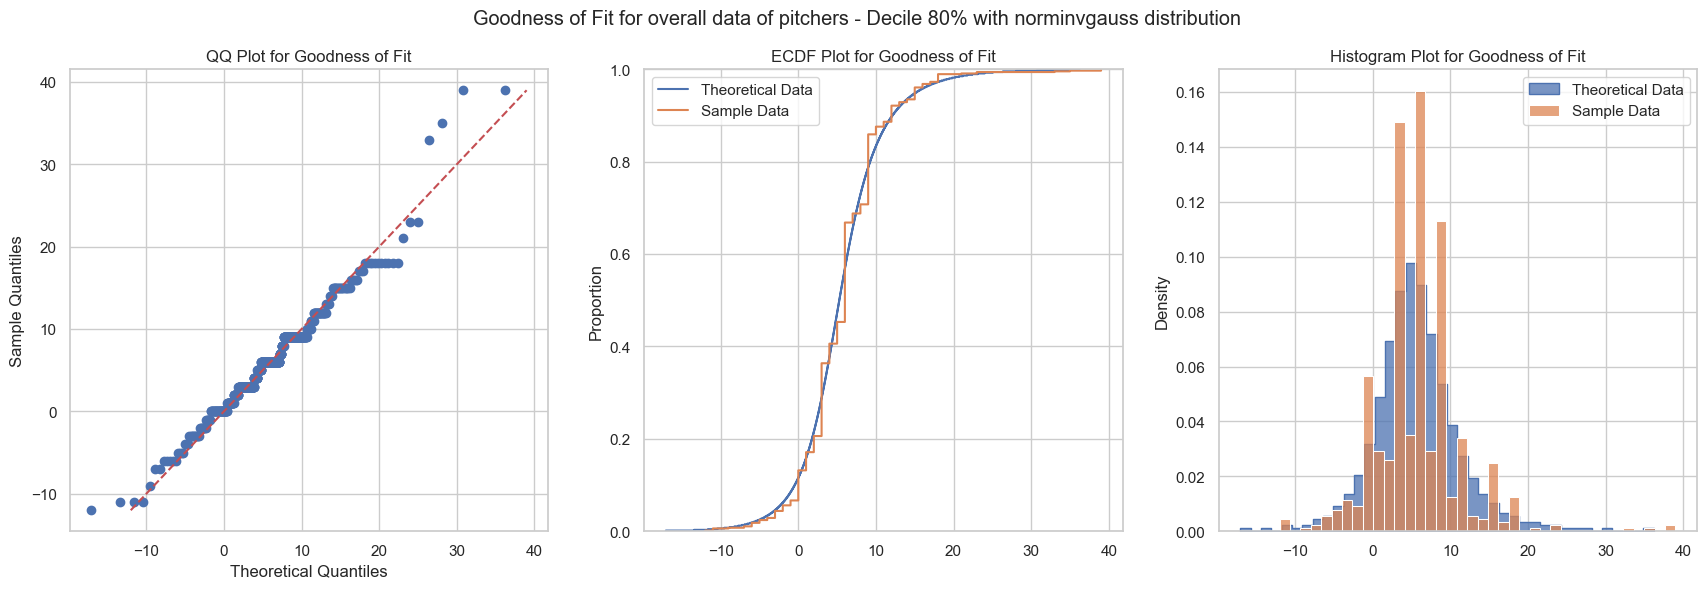

In [155]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with norminvgauss distribution"
)

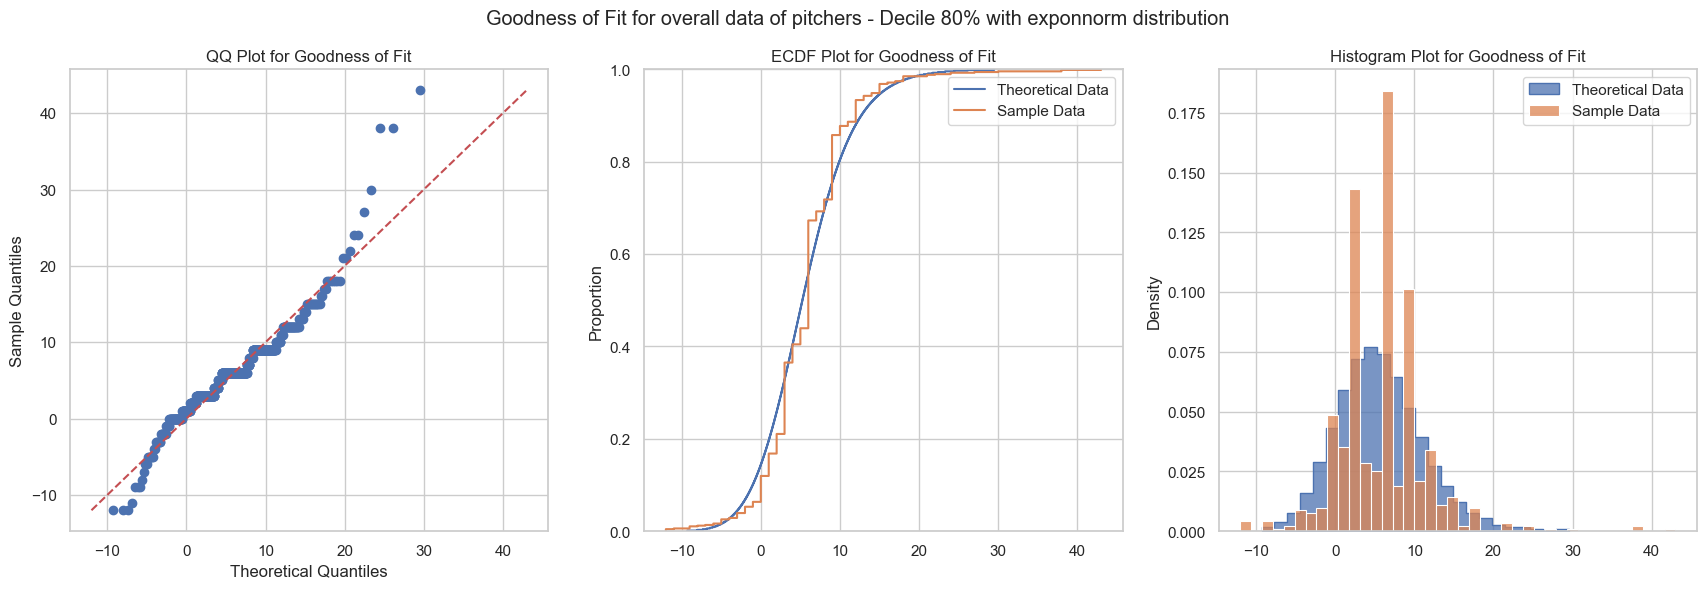

In [156]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(70, 80]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 80% with exponnorm distribution"
)

##### **Decile 90%**

In [157]:
fitters['(80, 90]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
norminvgauss  norminvgauss       0.077580  1194.541385  1221.639873   
hypsecant        hypsecant       0.077687  1234.525365  1248.074610   
tukeylambda    tukeylambda       0.077406  1162.120868  1182.444734   
johnsonsu        johnsonsu       0.077344  1159.112573  1186.211062   
t                        t       0.077160  1136.184690  1156.508557   
nct                    nct       0.077150  1141.179832  1168.278321   
exponnorm        exponnorm       0.078087  1484.568333  1504.892200   
burr12              burr12       0.077030  1317.881313  1344.979802   
logistic          logistic       0.077015  1325.302163  1338.851407   
mielke              mielke       0.077042  1281.993955  1309.092443   

              kullberg_divergence  ks_statistic    ks_p_value  \
norminvgauss                  inf      0.111350  2.639063e-70   
hypsecant                     inf      0.111471  1.857979e-70   
tukeylambda                   inf      0.112245  1.951425e-71   
johnsonsu                     inf      0.112878  3.056035e-72   
t                             inf      0.113945  1.308271e-73   
nct                           inf      0.114465  2.792436e-74   
exponnorm                     inf      0.115417  1.617226e-75   
burr12                        inf      0.115912  3.638157e-76   
logistic                      inf      0.116979  1.433502e-77   
mielke                        inf      0.117511  2.823523e-78   

                                                  fitted_params  
norminvgauss  {'a': 1.1914513510227573, 'b': -0.005335113580...  
hypsecant     {'loc': 5.256537158452425, 'scale': 3.16663252...  
tukeylambda   {'lam': -0.08659705921259742, 'loc': 5.2652868...  
johnsonsu     {'a': 0.012386617897142103, 'b': 1.53820848990...  
t             {'df': 4.7131212889690985, 'loc': 5.2718692460...  
nct           {'df': 4.726079678213546, 'nc': -0.03459615484...  
exponnorm     {'K': 0.48993110429196834, 'loc': 3.0644528580...  
burr12        {'c': 5113.92655225897, 'd': 0.965529600024716...  
logistic      {'loc': 5.268495510057751, 'scale': 2.67543077...  
mielke        {'k': 25.216600475502972, 's': 33.096666315884...

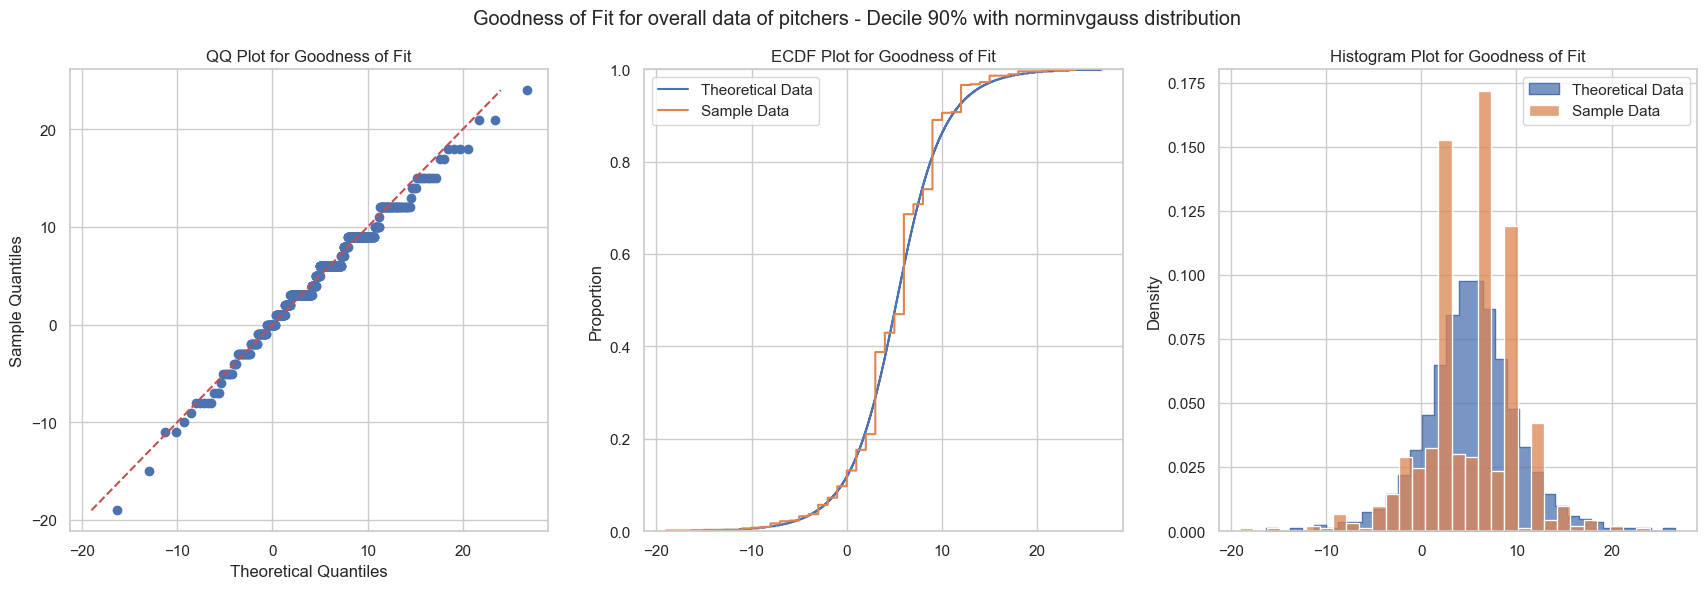

In [158]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(80, 90]'], 
    distribution_name="norminvgauss", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 90% with norminvgauss distribution"
)

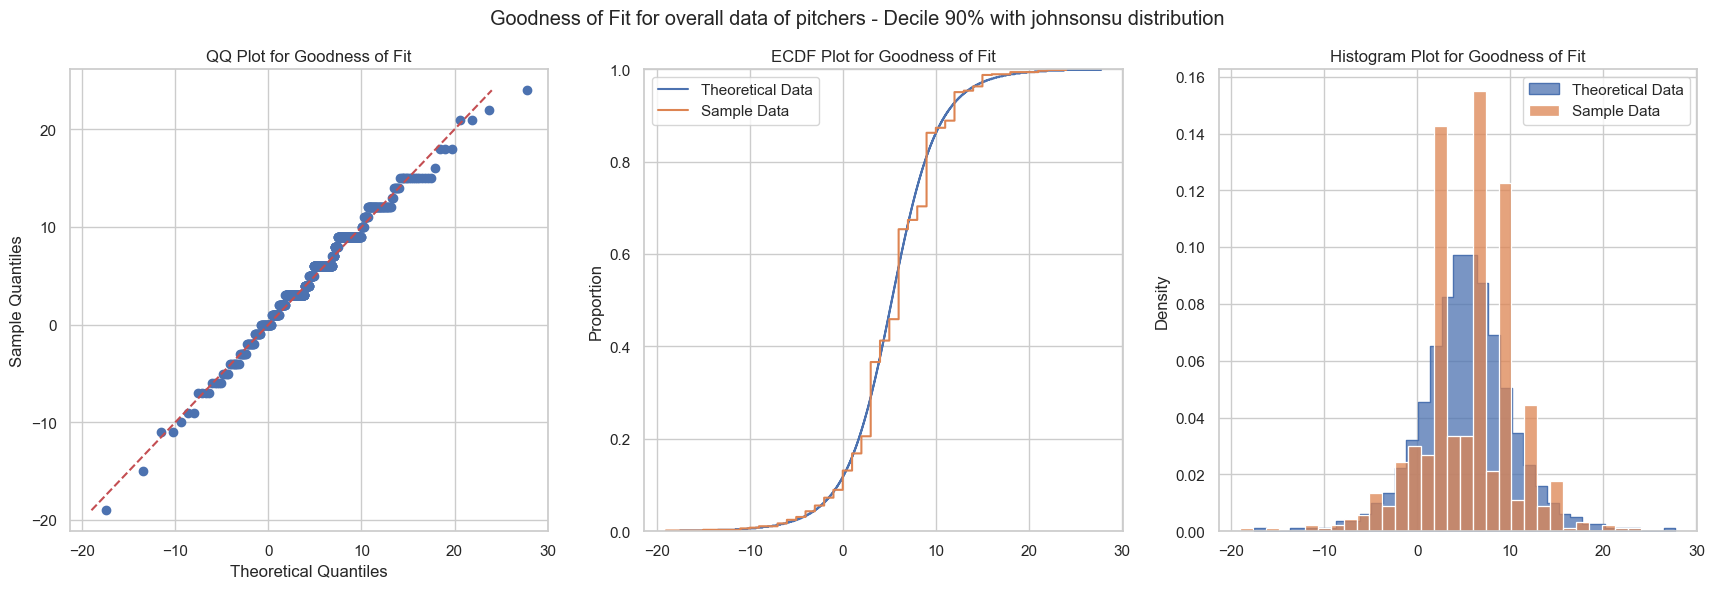

In [159]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(80, 90]'], 
    distribution_name="johnsonsu", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 90% with johnsonsu distribution"
)

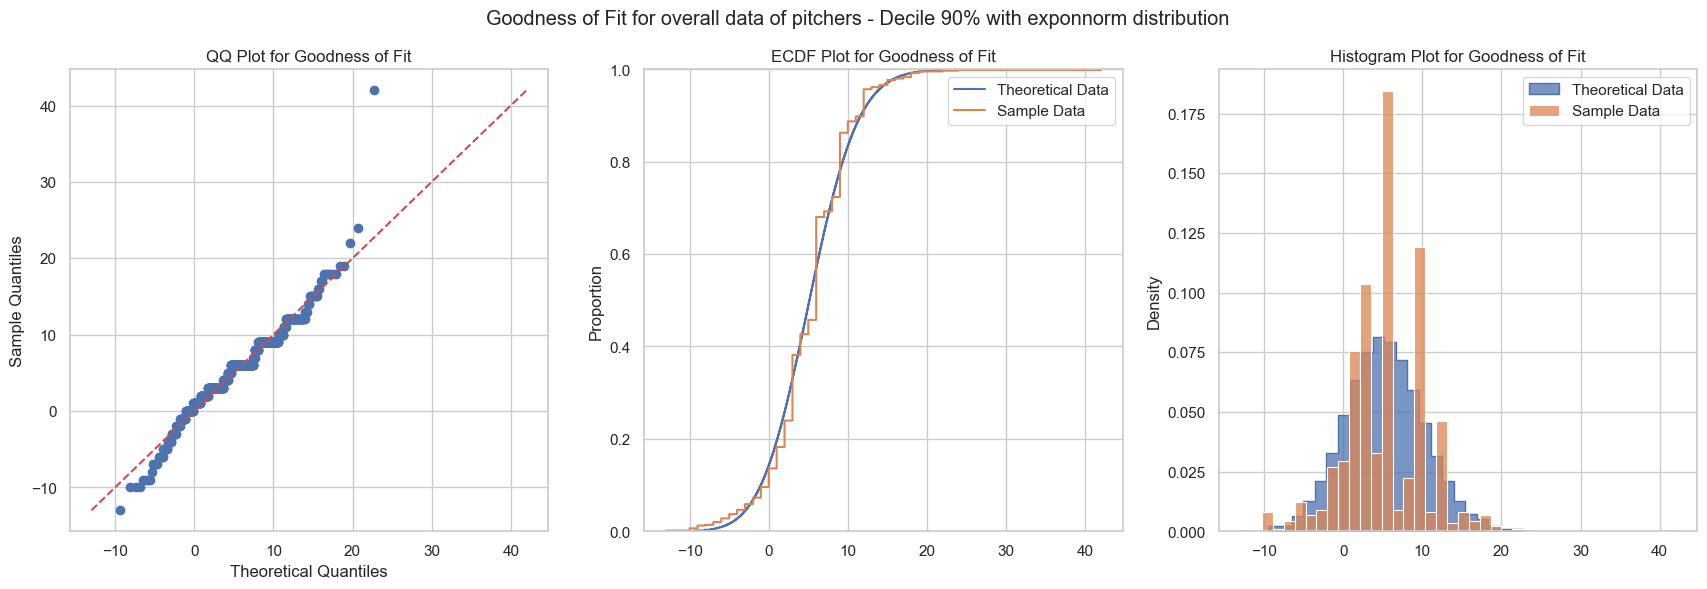

In [160]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(80, 90]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 90% with exponnorm distribution"
)

##### **Decile 100%**

In [161]:
fitters['(90, 100]'].summary(sort_by="ks_statistic", top_n=10)

distribution  squared_error          aic          bic  \
hypsecant      hypsecant       0.231589   902.104493   915.693233   
betaprime      betaprime       0.231472  1084.024271  1111.201752   
geninvgauss  geninvgauss       0.231544  1079.554391  1106.731872   
cauchy            cauchy       0.238674   804.330524   817.919264   
exponnorm      exponnorm       0.231420  1054.811803  1075.194914   
gausshyper    gausshyper       0.232536  1211.335914  1252.102136   
tukeylambda  tukeylambda       0.230956   913.818661   934.201772   
logistic        logistic       0.230661   937.431535   951.020276   
fisk                fisk       0.230661   939.437509   959.820620   
t                      t       0.230771   911.227748   931.610859   

             kullberg_divergence  ks_statistic    ks_p_value  \
hypsecant                    inf      0.114365  1.274685e-75   
betaprime                    inf      0.114463  9.470599e-76   
geninvgauss                  inf      0.114479  9.005470e-76   
cauchy                       inf      0.114508  8.244424e-76   
exponnorm                    inf      0.114769  3.723541e-76   
gausshyper                   inf      0.115778  1.700924e-77   
tukeylambda                  inf      0.115999  8.599399e-78   
logistic                     inf      0.116547  1.585998e-78   
fisk                         inf      0.116548  1.582236e-78   
t                            inf      0.116696  1.000859e-78   

                                                 fitted_params  
hypsecant    {'loc': 5.533821877719552, 'scale': 3.13577736...  
betaprime    {'a': 13219.936187336214, 'b': 7082.5421601103...  
geninvgauss  {'p': 1417.6353724667392, 'b': 1329.2634116367...  
cauchy       {'loc': 5.605485700280376, 'scale': 2.57770200...  
exponnorm    {'K': 0.36068626797646075, 'loc': 3.8148902821...  
gausshyper   {'a': 13.33757536115506, 'b': 62.5700195812316...  
tukeylambda  {'lam': -0.043996197510717996, 'loc': 5.532110...  
logistic     {'loc': 5.522872415702383, 'scale': 2.64555583...  
fisk         {'c': 35054839.93778211, 'loc': -92738521.0538...  
t            {'df': 5.721004917676147, 'loc': 5.53344109814...

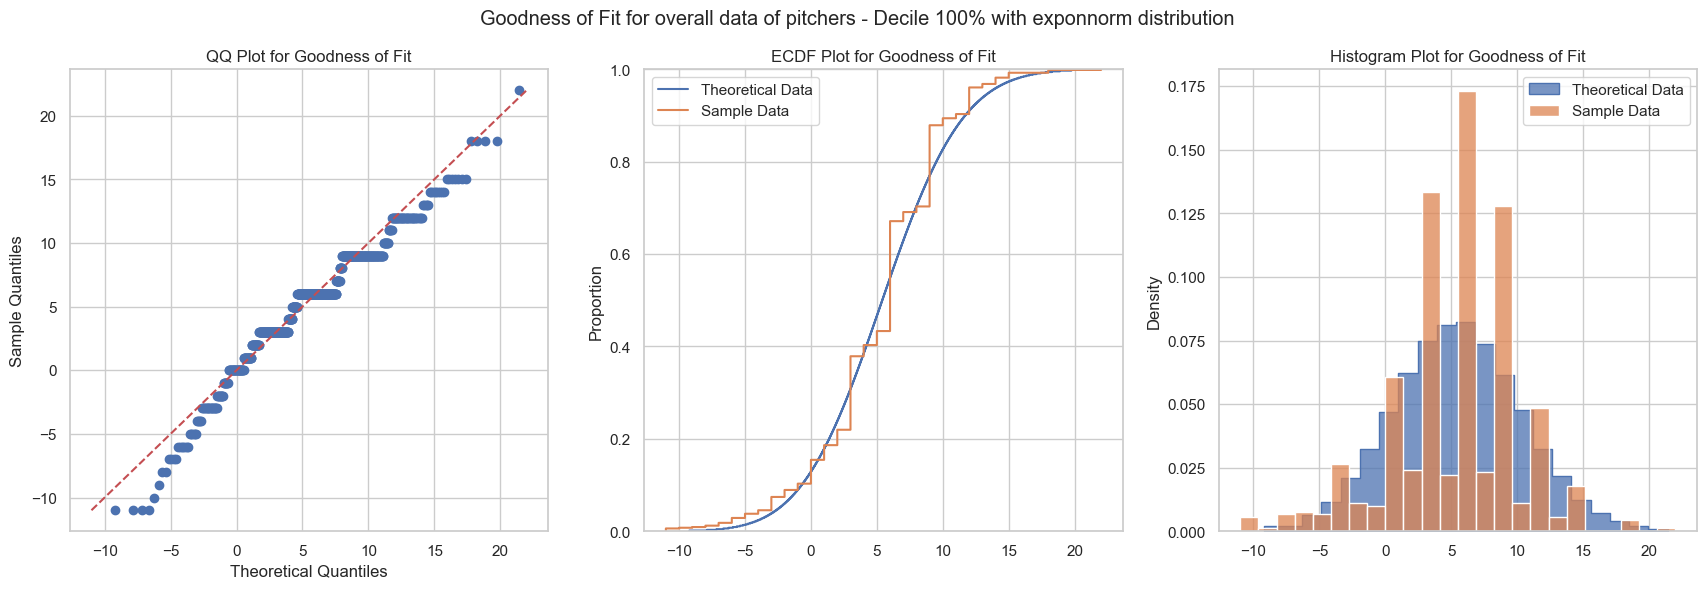

In [162]:
DistributionValidator().validate_goodness_of_fit(
    distribution_fitter=fitters['(90, 100]'], 
    distribution_name="exponnorm", 
    sample_proportion=0.1, 
    suptitle="Goodness of Fit for overall data of pitchers - Decile 100% with exponnorm distribution"
)

#### Pitchers dataframe for distributions

In [169]:
pitchers_distributions_df = pitchers_df\
.assign(
    row_number=pitchers_df\
    .groupby('player_info__player_id')['game_info__date']\
    .rank(method='first', ascending = False).astype(int)
).query("row_number == 1")[["player_info__player_id", "decile_group"]]

In [201]:
deciles_distributions = pd.DataFrame(
    [
        {"decile_group": "(0, 10]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(0, 10]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(10, 20]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(10, 20]"].get_distribution_parameters("exponnorm"))}, 
        {"decile_group": "(20, 30]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(20, 30]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(30, 40]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(30, 40]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(40, 50]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(40, 50]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(50, 60]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(50, 60]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(60, 70]", "decile_distribution": "genhyperbolic", "decile_parameters": str(fitters["(60, 70]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(70, 80]", "decile_distribution": "genhyperbolic", "decile_parameters": str(fitters["(70, 80]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(80, 90]", "decile_distribution": "norminvgauss", "decile_parameters": str(fitters["(80, 90]"].get_distribution_parameters("exponnorm"))},
        {"decile_group": "(90, 100]", "decile_distribution": "exponnorm", "decile_parameters": str(fitters["(90, 100]"].get_distribution_parameters("exponnorm"))},
    ]
)

In [203]:
pitchers_distributions_df = pitchers_distributions_df.assign(
    general_distribution="exponnorm",
    general_parameters=str(pitchers_distribution_fitter.get_distribution_parameters("exponnorm"))
).merge(right=deciles_distributions)